In [1]:
# Library setup
%reset -f
%matplotlib inline
import os
os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Versions/4.0/Resources"
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from lifelines.utils import concordance_index as c_index_score
from lights.inference import prox_QNMCEM
from lights.base.utils import visualize_vect_learning, plot_history
import numpy as np
from sklearn.preprocessing import StandardScaler
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from matplotlib import rc
rc('text', usetex=True)
%matplotlib inline

def printmd(string):
    display(Markdown(string))
    
import rpy2.robjects as robjects
from time import time

import warnings
%load_ext rpy2.ipython

In [2]:
%%R
defaultW <- getOption("warn") 
options(warn = -1) 

2 PBC dataset
=============

This dataset is a follow-up to the original dataset from the Mayo Clinic
trial in primary biliary cirrhosis (PBC) of the liver conducted between
1974 and 1984. A total of 424 PBC patients, referred to Mayo Clinic
during that ten-year interval, met eligibility criteria for the
randomized placebo controlled trial of the drug D-penicillamine. The
first 312 cases in the data set participated in the randomized trial and
contain largely complete data. The additional 112 cases did not
participate in the clinical trial, but consented to have basic
measurements recorded and to be followed for survival. Six of those
cases were lost to follow-up shortly after diagnosis, so the data here
are on an additional 106 cases as well as the 312 randomized
participants. The dataset contains only baseline measurements of the
laboratory paramters and contains multiple laboratory results, but only
on the first 312 patients. The data are in open-access in *JMbayes*
package.

2.3 Selection of training and test datasets
-------------------------------------------

To illustrate the competing models, 4/5 of the subjects (n=250) were
randomly selected to form the training data for fitting joint models,
and the remaining 1/5 (n=62) were used to form the test data for
evaluation of prediction.

In [3]:
%%R
data(pbc2, package = "JMbayes")
colnames <- names(pbc2)
data <- pbc2
data$T_long <- data$year
data$T_survival <- data$years
data$delta <- data$status2
data$SGOT <- log(data$SGOT)
data$serBilir <- log(data$serBilir)
data$albumin <- log(data$albumin)

# Select training and test samples
data$id <- as.numeric(data$id)
set.seed(2020)
lenght_id <- length(unique(data$id))
id_test <- sample(unique(data$id), round(lenght_id/5))

# training dataset
data_train <- data[which(!(data$id %in% id_test)), ]
data_train.id <- unique(data_train[, c("id", "T_survival", "delta", "drug", "sex", "age")])

# testing dataset
t_max <- 4
data_test <- data[which(data$id %in% id_test), ]
data_test.id <- unique(data_test[, c("id", "T_survival", "delta", "drug", "sex", "age")])

time_dep_feat = list("serBilir", "SGOT", "albumin")
time_indep_feat = list("age", "drug", "sex")

3 Lights
=======

In [4]:
# dataset setup
colnames_pbc2 = robjects.globalenv['colnames']
data_training = robjects.globalenv['data_train']
data_training = pd.DataFrame(data_training, index = data_training.colnames).T
data_testing = robjects.globalenv['data_test']
data_testing = pd.DataFrame(data_testing, index = data_testing.colnames).T
n_training_samples = data_training["id"].drop_duplicates().shape[0]
n_testing_samples = data_testing["id"].drop_duplicates().shape[0]
time_dep_feat = ["serBilir", "SGOT", "albumin"]
time_indep_feat = ["age", "drug", "sex"]
n_long_features = len(time_dep_feat)

In [5]:
# data preprocessing
# survival training data
survival_data_training = data_training[["id", "T_survival", "delta"] + time_indep_feat].drop_duplicates()
X_train = survival_data_training[time_indep_feat]
labelencoder = LabelEncoder()
X_train["drug"] = labelencoder.fit_transform(X_train["drug"])
X_train["sex"] = labelencoder.fit_transform(X_train["sex"])
X_train = X_train.values
X_train[:,1] = StandardScaler().fit_transform(X_train[:,1].reshape(-1, 1)).flatten()
T_train = survival_data_training[["T_survival"]].values.flatten()
delta_train = survival_data_training[["delta"]].values.flatten()

# longitunal training data
Y_train_ = data_training[["id", "T_long"] + time_dep_feat]
Y_train_[time_dep_feat] = StandardScaler().fit_transform(Y_train_[time_dep_feat])
Y_train = pd.DataFrame(columns=time_dep_feat)
id_list = np.unique(Y_train_["id"])
for i in range(n_training_samples):
    y_i = []
    for l in range(n_long_features):
        Y_il = Y_train_[["T_long", time_dep_feat[l]]][Y_train_["id"]==id_list[i]]
        # TODO: Add value of 1/365 (the first day of survey instead of 0)
        y_i += [pd.Series(Y_il[time_dep_feat[l]].values, index=Y_il["T_long"].values + 1/365)]
    Y_train.loc[i] = y_i
    
# survival testing data
survival_data_testing = data_testing[["id", "T_survival", "delta"]  + time_indep_feat].drop_duplicates()
X_test = survival_data_testing[time_indep_feat]
labelencoder = LabelEncoder()
X_test["drug"] = labelencoder.fit_transform(X_test["drug"])
X_test["sex"] = labelencoder.fit_transform(X_test["sex"])
X_test = X_test.values
X_test[:,1] = StandardScaler().fit_transform(X_test[:,1].reshape(-1, 1)).flatten()
T_test = survival_data_testing[["T_survival"]].values.flatten()
delta_test = survival_data_testing[["delta"]].values.flatten()

# longitunal testing data 
Y_test_ = data_testing[["id", "T_long"] + time_dep_feat]
Y_test_[time_dep_feat] = StandardScaler().fit_transform(Y_test_[time_dep_feat])
Y_test = pd.DataFrame(columns=time_dep_feat)
id_list = np.unique(Y_test_["id"])
for i in range(n_testing_samples):
    y_i = []
    for l in range(n_long_features):
        Y_il = Y_test_[["T_long", time_dep_feat[l]]][Y_test_["id"]==id_list[i]]
        y_i += [pd.Series(Y_il[time_dep_feat[l]].values, index=Y_il["T_long"].values + 1/365)]
    Y_test.loc[i] = y_i

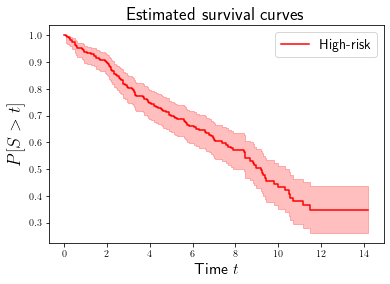

In [6]:
fontsize = 16
# Kaplan Meier estimation of survival curves
kmf = KaplanMeierFitter()
kmf.fit(T_train, delta_train, label="High-risk").plot(c='r')
plt.legend(fontsize=fontsize-2)
plt.xlabel('Time $t$', size=fontsize)
plt.ylabel(r'$P[S > t]$', size=fontsize+2)
plt.title("Estimated survival curves", size=fontsize+2)
plt.show()

### Visualize longitudinal processes for a randomly chosen

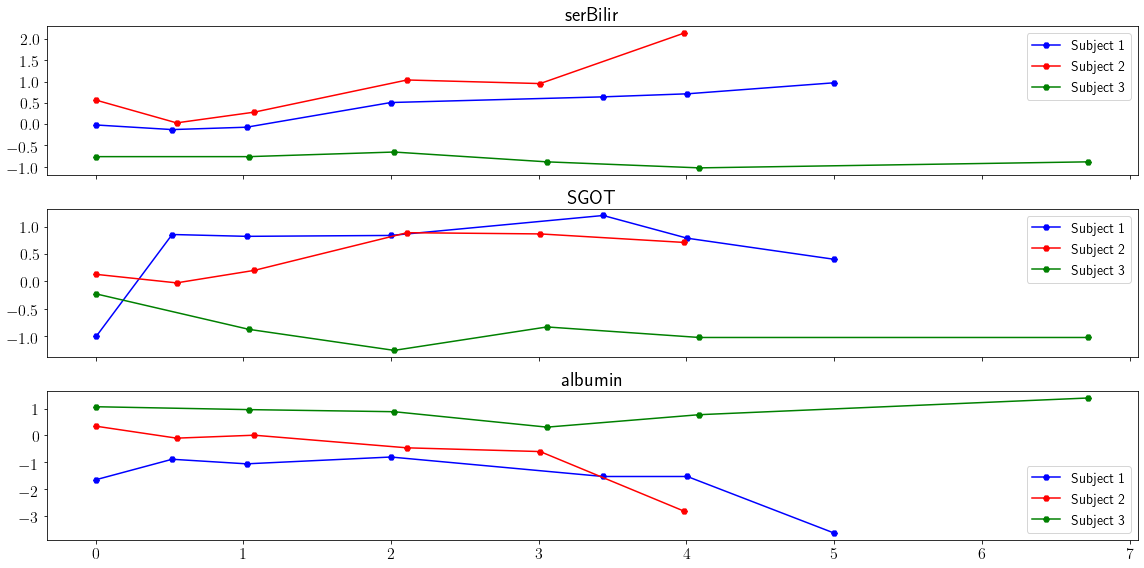

In [7]:
np.random.seed(10)
fig = plt.figure(figsize=(16, 8))
ax0 = plt.subplot(n_long_features,1,1)
colors, labels = ['b', 'r', 'g'], ['Subject 1', 'Subject 2', 'Subject 3']
idx_list = [2, 3, 4]
for k in [0, 1, 2]:
    #idx = np.random.choice(Y.index)
    idx = idx_list[k]
    Y_i = Y_train.loc[idx, :]
    label, color = labels[k], colors[k]
    for l in range(n_long_features):
        Y_il = Y_i[time_dep_feat[l]]
        ax = plt.subplot(n_long_features,1 ,l+1 , sharex=ax0)
        Y_il.plot(label=label, color=color, marker='H')
        ax.set_title(time_dep_feat[l], fontsize=fontsize+4)
        plt.xticks(fontsize=fontsize), plt.yticks(fontsize=fontsize)
        plt.legend(fontsize=fontsize-2)
fig.tight_layout()
plt.show()

Launching the solver prox_QNMCEM...
Launching the solver MLMM...
Launching the solver ULMM...


/Users/acsi/Working/lights/.env385/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Done solving using ULMM in 1.38e+00 seconds
 n_iter  |   obj    | rel_obj 
       0 |   4867.3 |      inf
       1 |  4396.61 | 9.67e-02
       2 |  4308.81 | 2.00e-02
       3 |  4264.45 | 1.03e-02
       4 |  4239.84 | 5.77e-03
       5 |  4225.17 | 3.46e-03
       6 |   4215.8 | 2.22e-03
       7 |  4209.42 | 1.51e-03
       8 |  4204.84 | 1.09e-03
       9 |  4201.43 | 8.11e-04
      10 |  4198.81 | 6.23e-04
Done solving using MLMM in 2.14e+00 seconds
 n_iter  |   obj    | rel_obj 
       0 |  49.5689 |      inf
       1 |  27.2757 | 4.50e-01
       2 |  25.1486 | 7.80e-02
       3 |  23.2732 | 7.46e-02
       4 |  22.7167 | 2.39e-02
       5 |  22.3403 | 1.66e-02
       6 |  22.0963 | 1.09e-02
       7 |  22.0838 | 5.67e-04
       8 |  21.9459 | 6.24e-03
       9 |  21.8321 | 5.19e-03
      10 |  21.8026 | 1.35e-03
Done solving using prox_QNMCEM in 1.52e+02 seconds


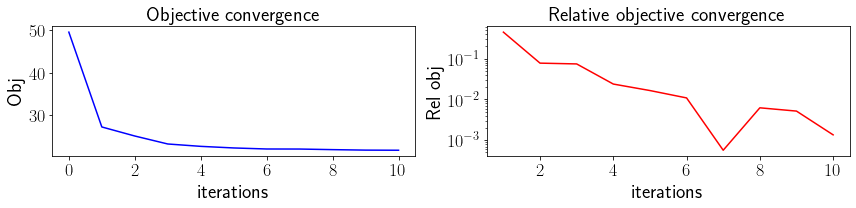

In [8]:
## Choose parameters ##
tol = 1e-6            # tolerance for the convergence stopping criterion 
eta = 0.3             # parameter controlling the trade-off between l1 
                      # and l2 regularization in the elasticNet
gamma_chosen = '1se'  # way to select l_elasticNet_chosen: '1se' or 'min'
warm_start = True     # at each L-BGFS-B iteration, reset beta to 0 or take 
                      # the previous value 
grid_size = 30        # grid size for the cross validation procedure
metric = 'C-index'    # cross-validation metric: 'log_lik' or 'C-index'

start = time()
# declare learner here
fixed_effect_time_order = 1
learner = prox_QNMCEM(fixed_effect_time_order=fixed_effect_time_order,
                max_iter=10, initialize=True, print_every=1,
               compute_obj=True, simu=False, asso_functions=["lp", "re"],
                      l_pen_SGL=0.02, eta_sp_gp_l1=.9, l_pen_EN=0.02)
learner.fit(X_train, Y_train, T_train, delta_train)

lights_marker = learner.predict_marker(X_test, Y_test)
lights_c_index = c_index_score(T_test, lights_marker, delta_test)
lights_c_index = max(lights_c_index, 1 - lights_c_index)
lights_exe_time = time() - start

# Visualize learning
visualize_vect_learning(learner, "obj")

In [9]:
def visualize_vect_learning_pbc(learner, name, symbol = None,
                            legend_est = None, legend_true = None):
    """Plots learning for a given parameter vector : objective and relative
    objective function, as well as evolution of estimators through iterations

    Parameters
    ----------
    learner : `ligths.base.base.Learner`
        A base learner

    name : `str`
        Name of the element to be plotted

    symbol : `str`
        Symbol of the element to be plotted

    legend_est : `list`
        Names of each estimator coefficients

    legend_true : `list`
        Names of each true parameter coefficients
    """
    fs = 18
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111)
    plt.title("%s learning" % symbol, fontsize=fs + 2)
    plt.xlabel('iterations', fontsize=fs + 2)
    plt.xticks(fontsize=fs), plt.yticks(fontsize=fs)
    cm = 'Dark2'
    plot_history(learner, name=name, ax=ax, colormap=cm, alpha=.8)

    legend1 = ax.legend(legend_est, loc='center right',
                        bbox_to_anchor=(-0.1, 0.5), fontsize=fs)
    plt.gca().add_artist(legend1)

    fig.tight_layout()
    plt.show()

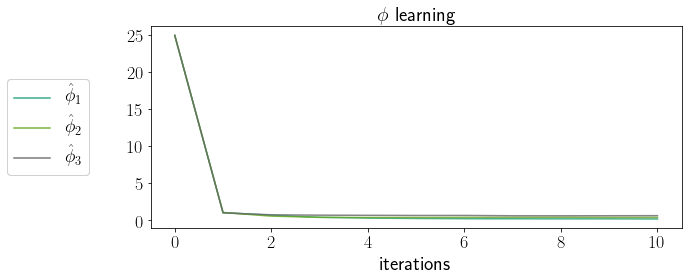

In [10]:
# Visualize phi
to = len(learner.theta["phi"])+1
leg1 = [r"$\hat \phi_%s$" % j for j in range(1, to)]
leg2 = [r"$\phi_%s$" % j for j in range(1, to)]
visualize_vect_learning_pbc(learner, "phi", symbol = r"$\phi$", legend_est = leg1, legend_true = leg2)

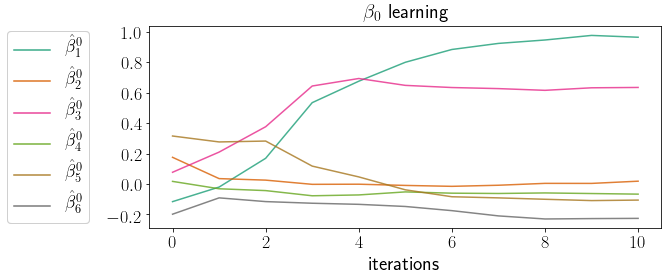

In [11]:
# Visualize beta_0
to = len(learner.theta["beta_0"])+1
leg1 = [r"$\hat \beta^0_%s$" % j for j in range(1, to)]
leg2 = [r"$\beta^0_%s$" % j for j in range(1, to)]
visualize_vect_learning_pbc(learner, "beta_0", r"$\beta_0$", leg1, leg2)

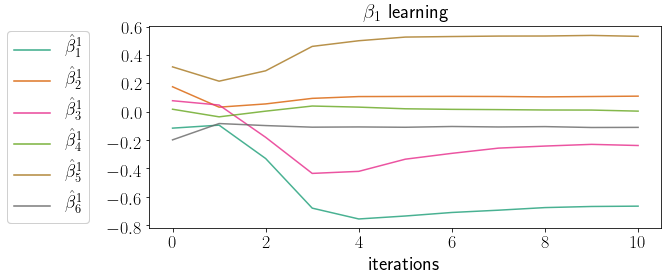

In [12]:
# Visualize beta_1
to = len(learner.theta["beta_1"])+1
leg1 = [r"$\hat \beta^1_%s$" % j for j in range(1, to)]
leg2 = [r"$\beta^1_%s$" % j for j in range(1, to)]
visualize_vect_learning_pbc(learner, "beta_1", r"$\beta_1$", leg1, leg2)

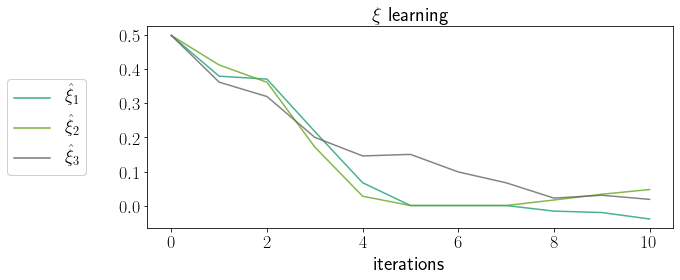

In [13]:
# Visualize xi
to = len(learner.theta["xi"])+1
leg1 = [r"$\hat \xi_%s$" % j for j in range(1, to)]
leg2 = [r"$\xi_%s$" % j for j in range(1, to)]
visualize_vect_learning_pbc(learner, "xi", r"$\xi$", leg1, leg2)

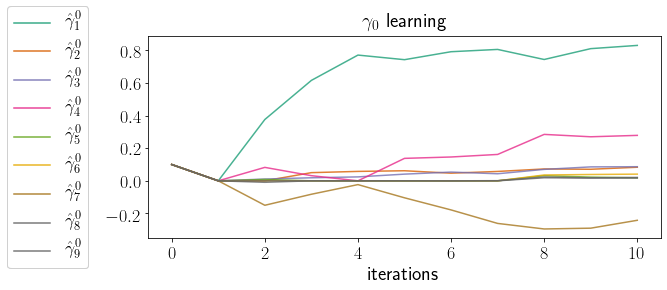

In [14]:
# Visualize gamma_0
to = len(learner.theta["gamma_0"])+1
leg1 = [r"$\hat \gamma^0_{%s}$" % j for j in range(1, to)]
leg2 = [r"$\gamma^0_{%s}$" % j for j in range(1, to)]
visualize_vect_learning_pbc(learner, "gamma_0", r"$\gamma_0$", leg1, leg2)

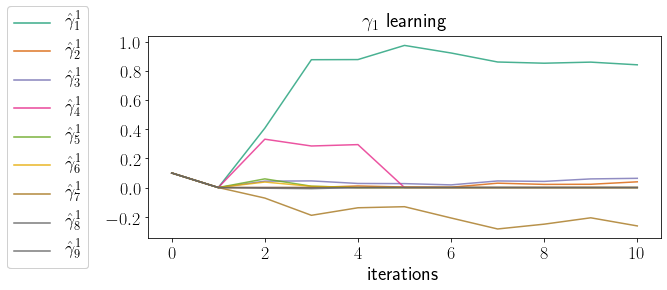

In [15]:
# Visualize gamma_0
to = len(learner.theta["gamma_1"])+1
leg1 = [r"$\hat \gamma^1_{%s}$" % j for j in range(1, to)]
leg2 = [r"$\gamma^1_{%s}$" % j for j in range(1, to)]
visualize_vect_learning_pbc(learner, "gamma_1", r"$\gamma_1$", leg1, leg2)

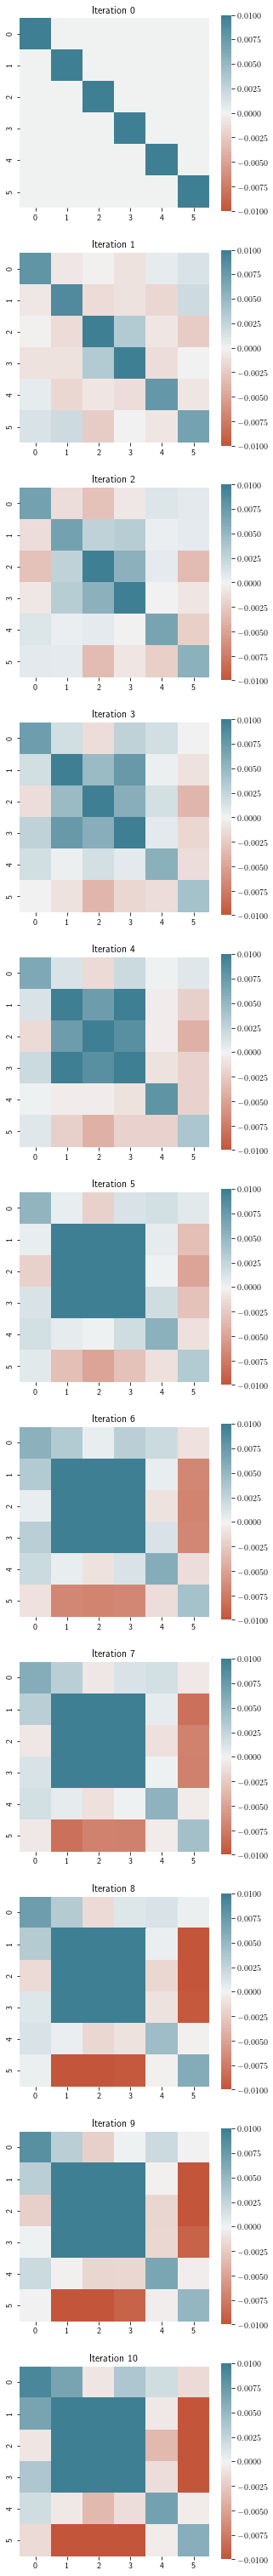

In [16]:
long_cov_history = learner.history.values["long_cov"]
fig, axes = plt.subplots(len(long_cov_history), 1, figsize=(5, 5 * len(long_cov_history)), sharey=True)
for i in range(len(long_cov_history)):
    sns.heatmap(
    data=long_cov_history[i], 
    vmin=-.01, vmax=.01, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, ax=axes[i]
    )
    axes[i].set_title("Iteration {}".format(i))

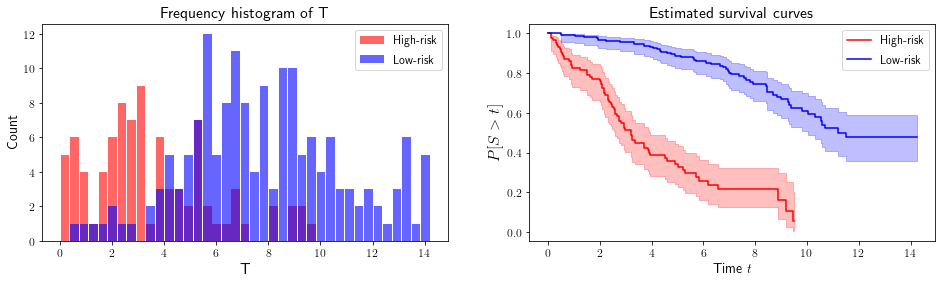

In [17]:
fig = plt.figure(figsize=(16, 4))
fontsize = 14
ax = fig.add_subplot(1,2,1)
bins = np.linspace(0, T_train.max(), 40)
kwargs = dict(bins=bins, alpha=0.6, rwidth=0.9)
plt.hist(T_train[learner.pi_est < .5], **kwargs, color='r', label='High-risk')
plt.hist(T_train[learner.pi_est > .5], **kwargs, color='b', label='Low-risk')
plt.legend(fontsize=fontsize-2)
plt.xlabel("T", size=fontsize+2)
plt.ylabel("Count", size=fontsize)
ax.tick_params(labelsize=fontsize-2)
plt.title("Frequency histogram of T", size=fontsize+2)

# Kaplan Meier estimation of survival curves
kmf = KaplanMeierFitter()
ax = plt.subplot(122)
kmf.fit(T_train[learner.pi_est < .5], delta_train[learner.pi_est < .5], label="High-risk").plot(ax=ax, c='r')
kmf.fit(T_train[learner.pi_est > .5], delta_train[learner.pi_est > .5], label="Low-risk").plot(ax=ax, c='b')
plt.legend(fontsize=fontsize-2)
plt.xlabel('Time $t$', size=fontsize)
plt.ylabel(r'$P[S > t]$', size=fontsize+2)
plt.title("Estimated survival curves", size=fontsize+2)
ax.tick_params(labelsize=fontsize-2)
plt.show()

3 Competing models
==================

4.1 Penalized Cox model with time-independent features.
-------------------------------------------------------

The first model we consider as a baseline is the well known Cox PH model
with time-independent features. In this model introduced in
{Cox1972JRSS}, a parameter vector $\beta$ is estimated by minimizing the
partial log-likelihood given by 

$$
\ell_n^{\text{cox}}(\beta) = n^{-1} \sum_{i=1}^n \delta_i \big(
x_i^\top \beta - \log \sum_{i' : t_{i'} \geq t_i}
\text{exp}(x_{i'}^\top \beta) \big).
$$

We use respectively the **R** packages *survival* and *glmnet*
{simon2011regularization} for the partial log-likelihood and the
minimization of the following quantity

$$
- \ell_n^{\text{cox}}(\beta) + \xi \big( (1-\eta)||\beta||_1
+ \frac{\eta}{2} ||\beta||_2^2 \big),
$$

where $\xi$ is chosen by the a 10-fold cross-validation procedure, for a given $\eta \in [0, 1]$. Ties are handled
via the Breslow approximation of the partial likelihood . We also choose to include basic time-independent features extracted from longitudinal processes, that is values of longitudinal processes at time $t_{max}$ for each time-dependant feature.

In [18]:
%%R
library(lcmm)
library(glmnet)

# function to get longitudinal features
lfeatures <- function(model, formFixed, formRandom, data.id, col_name = "") {
    data.id$T_long <- data.id$T_survival
    mfX.id <- model.frame(formFixed, data = data.id)
    mfU.id <- model.frame(formRandom, data = data.id)
    Xtime <- model.matrix(formFixed, mfX.id)
    Utime <- model.matrix(formRandom, mfU.id)

    # subject-specific random effects
    RE <- model$predRE[, -1]
    value <- Xtime %*% model$best[1:ncol(Xtime)] + diag(Utime %*% t(RE))

    return(value)
}

Cox_get_feat <- function(data, time_dep_feat, time_indep_feat, alpha) {
    # combination time-indep and time-dep features
    X <- c()
    data.id <- data[!duplicated(as.integer(data[all.vars(~id)][, 1])), ]
    long_model <- list()
    long_feat <- list()
    for(i in 1:length(time_dep_feat)) {
        formFixed = as.formula(paste(time_dep_feat[[i]], " ~ T_long + I(T_long^alpha)"))
        formRandom = ~T_long
        long_model[[i]] <- hlme(fixed = formFixed, random = formRandom, subject = "id", 
                                ng = 1, data = data)
        long_feat[[i]] <- lfeatures(model = long_model[[i]],
                               formFixed = formFixed, formRandom = formRandom,
                               col_name = time_dep_feat[[i]], data.id = data.id)
        # combine longitudinal features
        X <- cbind(X, long_feat[[i]])
    }
    for(i in 1:length(time_indep_feat)) {
        time_indep <- data.id[[time_indep_feat[[i]]]]
        # combine time-independent features
        X <- cbind(X, time_indep)
    }
    colnames(X) <- cbind(time_dep_feat, time_indep_feat)

    return(X)
}

X_train <- Cox_get_feat(data_train, time_dep_feat, time_indep_feat, alpha=2)
X_test <- Cox_get_feat(data_test, time_dep_feat, time_indep_feat, alpha=2)

# do cross-validation and use the best penality parameter
cv.coxnet.fit <- cv.glmnet(X_train, Surv(data_train.id$T_survival, data_train.id$delta),
                           family = "cox", alpha = 1, nfolds = 10)
best.lambda <- cv.coxnet.fit$lambda.min

R[write to console]: Le chargement a nécessité le package : survival

R[write to console]: Le chargement a nécessité le package : parallel

R[write to console]: Le chargement a nécessité le package : Matrix

R[write to console]: Loaded glmnet 4.1-1



Be patient, hlme is running ... 
The program took 0.25 seconds 
Be patient, hlme is running ... 
The program took 0.29 seconds 
Be patient, hlme is running ... 
The program took 0.25 seconds 
Be patient, hlme is running ... 
The program took 0.07 seconds 
Be patient, hlme is running ... 
The program took 0.09 seconds 
Be patient, hlme is running ... 
The program took 0.09 seconds 


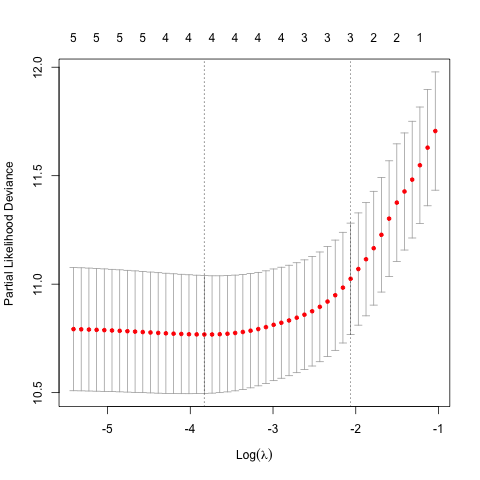

In [19]:
%%R
plot(cv.coxnet.fit)

In [20]:
%%R
start_time <- Sys.time()
Coxnet_trained_model <- glmnet(X_train, Surv(data_train.id$T_survival, data_train.id$delta),
                     family = "cox", lambda = best.lambda, alpha = 1)
end_time <- Sys.time()
Coxnet_run_time <- end_time - start_time
Coxnet_marker <- predict(Coxnet_trained_model, newx = X_test, type = "response")

In [21]:
%%R
head(Coxnet_marker)

           s0
1   11539.839
35   5485.329
72   3760.205
150 11556.292
153 33748.105
168  1415.609


4.2 Multivariate joint latent class model.
------------------------------------------

Among joint modeling approaches, a multivariate version of JLCMs is considered. Several longitudinal markers and time-to-event data are jointly fitted assuming that that the behavior of each response is determined by belonging to a latent homogeneous subpopulation. Contrary to the lights model, there are no shared associations between the
longitudinal models and the survival model. Given the group membership, each submodel are assumed to be independent. Therefore, the predictive marker is 

$$
\hat{\mathcal{R}}_{ik}^{(lcmm)} = \frac{\pi_{k}(\hat \theta)
\hat f(t^{max}_i \| G_i=k ; \hat \theta)\hat f(y_i | G_i=k ;
\hat \theta)}{\sum_{k=0}^{K-1} \pi_{k}(\hat \theta) \hat
f(t^{max}_i \| G_i=k ; \hat \theta)\hat f(y_i \| G_i=k ; \hat
\theta)}, 
$$

where each quantities are already defined
assuming only latent class approach. The multivariate JLCM is
implemented by {proust2017lcmm} in the **R** package *lcmm*.

In [34]:
%%R
start_time <- Sys.time()
fixed_form <<- formula(paste(paste(time_dep_feat, collapse = ' + '), " ~ T_long + I(T_long^2)"))
trained_long_model <- do.call(multlcmm, args = list(fixed_form, random = ~T_long, subject = "id",
                        nwg = TRUE, ng = 2, mixture = ~T_long + I(T_long^2),
                        data = data, maxiter = 0))
mixture_form <- vector()
for(i in 1 : length(time_indep_feat)){
    mixture_form[i] <- paste("mixture(", time_indep_feat[i], ")")
}
classmb_form <- as.formula(paste("~ ", paste(time_indep_feat, collapse = ' + ')))
survival_form <- as.formula(paste("Surv(T_survival, delta) ~ ", paste(mixture_form, collapse = ' + ')))
trained_joint_model <- do.call(mpjlcmm, args = list(longitudinal = list(trained_long_model), subject = "id",
                       ng = 2, data = data_train, classmb = classmb_form,
                       survival = survival_form, hazard = "Weibull", hazardtype = "PH"))
end_time <- Sys.time()
MJLCMM_run_time <- end_time - start_time

mjlcmm_pred <- do.call(mpjlcmm, list(longitudinal = list(trained_long_model), B = trained_joint_model$best,
                         maxiter = 0, subject = "id", ng = 2, data = data_test,
                         classmb = classmb_form, survival = survival_form,
                         hazard = "Weibull", hazardtype = "PH"))
MJLCMM_marker <- mjlcmm_pred$pprob$probYT1

Be patient, multlcmm is running ... 
The program took 0.16 seconds 
The program took 536.65 seconds 
The program took 0.07 seconds 


In [23]:
%%R
summary(trained_joint_model)

Multivariate joint latent class model for quantitative outcome and competing risks 
     fitted by maximum likelihood method 
 
(function (longitudinal, subject, classmb, ng, survival, hazard = "Weibull", 
    hazardtype = "Specific", hazardnodes = NULL, TimeDepVar = NULL, 
    data, B, convB = 1e-04, convL = 1e-04, convG = 1e-04, maxiter = 100, 
    nsim = 100, prior, logscale = FALSE, subset = NULL, na.action = 1, 
    posfix = NULL, partialH = FALSE, verbose = TRUE) 
{
    ptm <- proc.time()
    cl <- match.call()
    if (!is.list(longitudinal)) 
        stop("longitudinal should be a list of estimated models")
    longclass <- unique(sapply(longitudinal, class))
    if (any(!(longclass %in% c("hlme", "lcmm", "multlcmm")))) 
        stop("longitudinal should only contain hlme, lcmm or multlcmm objects")
    if (length(longclass) != 1) 
        stop("longitudinal should only contain objects of the same class")
    if (!missing(classmb) & ng == 1) 
        stop("No classmb can be spec

            form1 <- formula(paste("~", form1))
            asurv1 <- terms(form1, specials = "cause")
            ind.cause <- attr(asurv1, "specials")$cause
            if (length(ind.cause)) {
                form.cause <- paste(labels(asurv1)[ind.cause], 
                  collapse = "+")
                form.cause <- gsub("cause", "", form.cause)
                form.cause <- formula(paste("~", form.cause))
            }
            else {
                form.cause <- ~-1
            }
            form.causek <- vector("list", nbevt)
            for (k in 1:nbevt) {
                formk <- gsub("mixture", "", form.surv)
                for (kk in 1:nbevt) {
                  if (kk != k) 
                    formk <- gsub(paste("cause", kk, sep = ""), 
                      "", formk)
                }
                asurvk <- terms(formula(paste("~", formk)), specials = paste("cause", 
                  k, sep = ""))
                ind.causek <- attr(asurvk, "specials")$cause

        nobs[k] <- nrow(xk)
        idiag[k] <- mod$idiag
        npmtot[k] <- length(mod$best) - mod$N[1]
        p1[k] <- sum(mod$idg == 1)
        p2[k] <- sum(mod$idg == 2)
        ctr[k] <- sum(mod$idcontr)
        q[k] <- sum(mod$idea)
        nvc[k] <- ifelse(idiag[k] == 1, q[k], q[k] * (q[k] + 
            1)/2)
        ncor[k] <- mod$N[5 + contrainte]
        nw[k] <- ifelse(contrainte == 2, mod$N[5], mod$N[4])
        if (contrainte == 0) 
            idlink[sum(ny[1:k]) - ny[k] + 1:ny[k]] <- -1
        else idlink[sum(ny[1:k]) - ny[k] + 1:ny[k]] <- mod$linktype
        if (contrainte == 2) {
            ncontr[k] <- mod$N[2]
            nalea[k] <- mod$N[6]
            nbtmp <- rep(2, ny[k])
            nbtmp[which(mod$linktype == 2)] <- mod$nbnodes
            nbzitr[sum(ny[1:k]) - ny[k] + 1:ny[k]] <- nbtmp
            nodes <- c(nodes, as.vector(mod$linknodes))
            if (nrow(zitr) < max(nbtmp)) {
                zitr <- rbind(zitr, matrix(0, nrow = max(nbtmp) - 
   

                if (hazard[i] == "Weibull") 
                  next
                ii <- ii + 1
                nz[i] <- as.numeric(haz13[[ii]][1])
                if (nz[i] < 3) 
                  stop("At least 3 nodes are required")
                typrisq[i] <- ifelse(haz13[[ii]][3] %in% c("splines", 
                  "Splines"), 3, 1)
                nprisq[i] <- ifelse(haz13[[ii]][3] %in% c("splines", 
                  "Splines"), nz[i] + 2, nz[i] - 1)
                locnodes <- c(locnodes, haz13[[ii]][2])
                if (!(haz13[[ii]][3] %in% c("splines", "Splines", 
                  "piecewise", "Piecewise"))) 
                  stop("Invalid argument hazard")
                if ((haz13[[ii]][2] == "manual")) {
                  if (typrisq[i] == 1 | dejaspl == 0) {
                    if (length(arghaz) > 1 | i == 1) {
                      nbnodes <- nbnodes + nz[i] - 2
                    }
                  }
                  if (typrisq[i] == 3) 
                

                  next
                for (k in 1:nbevt) {
                  if (idspecif[k, j] == 1) {
                    nvarxevt <- nvarxevt + 1
                    nvarxevt2 <- nvarxevt2 + 1
                  }
                  if (idspecif[k, j] == 2) {
                    nvarxevt <- nvarxevt + ng
                    nvarxevt2 <- nvarxevt2 + 1
                  }
                }
            }
        }
    }
    nea <- q
    predRE <- rep(0, ns * sum(nea))
    predRE_Y <- rep(0, ns * sum(nalea))
    if (contrainte == 0) 
        nef <- p1 + ng * p2
    else nef <- p1 + ng * p2 - 1
    if (contrainte == 2) 
        nvc <- nvc - 1
    else nvc <- nvc
    if (contrainte == 1) 
        nerr <- rep(0, K)
    else nerr <- ny
    nprob <- (ng - 1) * sum(idprob)
    neftot <- sum(nef)
    ncontrtot <- sum(ncontr)
    nvctot <- sum(nvc)
    nwtot <- sum(nw)
    ncortot <- sum(ncor)
    nerrtot <- ifelse(contrainte == 1, 0, sum(ny))
    naleatot <- sum(nalea)
    ntrtot <- sum(ntr)
  

            }
        }
    }
    nom.X0 <- colnames(X0)
    nom.X0[which(nom.X0 == "(Intercept)")] <- "intercept"
    nom.Xns0 <- colnames(Xns0)
    nom.Xns0[which(nom.Xns0 == "(Intercept)")] <- "intercept"
    if (ng >= 2) {
        nom <- rep(nom.Xns0[idprob == 1], each = ng - 1)
        nom1 <- paste(nom, " class", c(1:(ng - 1)), sep = "")
        names(b)[1:nprob] <- nom1
    }
    if (nbevt > 0) {
        if (isTRUE(logscale)) {
            for (i in 1:nbevt) {
                nom1 <- rep(paste("event", i, sep = ""), nrisq[i])
                if (typrisq[i] == 2) {
                  nom2 <- paste(nom1[1:2], " log(Weibull", 1:2, 
                    ")", sep = "")
                  nom1[1:(2 * ifelse(risqcom[i] == 0, ng, 1))] <- rep(nom2, 
                    ifelse(risqcom[i] == 0, ng * (risqcom[i] == 
                      0), 1))
                  if (risqcom[i] == 2) 
                    nom1[2 + 1:(ng - 1)] <- paste(nom1[2 + 1:(ng - 
                      1)], "SurvPH")
     

                      classg <- paste("class", 1:ng, sep = "")
                      nom1 <- c(nom1, paste(xevtk, classg))
                    }
                    next
                  }
                }
            }
        }
        if (nvarxevt > 0) 
            names(b)[nprob + nrisqtot + 1:nvarxevt] <- nom1
    }
    tmp <- 0
    for (k in 1:K) {
        mod <- get(paste("mod", k, sep = ""))
        if (ng > 1) {
            names(b)[nprob + nrisqtot + nvarxevt + tmp + 1:npmtot[k]] <- names(mod$best[-(1:(ng - 
                1))])
        }
        else {
            names(b)[nprob + nrisqtot + nvarxevt + tmp + 1:npmtot[k]] <- names(mod$best)
        }
        tmp <- tmp + npmtot[k]
    }
    idnv0 <- c(idg0, idcontr0, idea0, idcor0)
    idnv2 <- c(idprob, idcom, idtdv)
    idspecif <- as.vector(t(idspecif))
    int3 <- c(idtrunc, logspecif, maxiter)
    convBLG <- c(convB, convL, convG)
    out <- .Fortran(C_mpjhet, as.integer(K), as.integer(ny), 
        as.integer(nbevt),

    temp <- paste("pred_m", 1:ng, sep = "")
    temp1 <- paste("pred_ss", 1:ng, sep = "")
    colnames(pred) <- c(nom.subject, "Yname", "pred_m", "resid_m", 
        "pred_ss", "resid_ss", "obs", temp, temp1)
    if (nbevt > 0) {
        risqcum_est <- matrix(out$risqcum_est, nrow = nsim, ncol = ng * 
            nbevt)
        risq_est <- matrix(out$risq_est, nrow = nsim, ncol = ng * 
            nbevt)
        predSurv <- cbind(time, risq_est, risqcum_est)
        temp <- paste(paste("event", rep(1:nbevt, each = ng), 
            ".RiskFct", sep = ""), 1:ng, sep = "")
        temp1 <- paste(paste("event", rep(1:nbevt, each = ng), 
            ".CumRiskFct", sep = ""), 1:ng, sep = "")
        colnames(predSurv) <- c("time", temp, temp1)
        rownames(predSurv) <- 1:nsim
    }
    else {
        predSurv <- NA
    }
    ysim <- matrix(out$marker, nsim, sum(ny))
    transfo <- matrix(out$transfY, nsim, sum(ny))
    estimlink <- as.vector(rbind(ysim, transfo))
    estimlink <- matrix(

    fixed2 <- gsub("contrast", "", fixed)
    fixed2 <- formula(paste(fixed2[2], fixed2[3], sep = "~"))
    afixed2 <- terms(fixed2)
    variables <- c(attr(afixed, "variables"), attr(arandom, "variables"), 
        attr(amixture, "variables"), attr(aclassmb, "variables"))
    variables <- unlist(lapply(variables, all.vars))
    if (!all(variables %in% colnames(data))) 
        stop(paste("Data should contain the variables", paste(unique(variables), 
            collapse = " ")))
    contr <- ~-1
    if (!is.null(attr(afixed, "specials")$contrast)) {
        vcontr <- attr(afixed, "term.labels")[setdiff(attr(afixed, 
            "specials")$contrast - 1, untangle.specials(afixed, 
            "contrast", 2)$terms)]
        vcontr <- gsub("contrast", "", vcontr)
        contr <- as.formula(paste("~-1+", paste(vcontr, collapse = "+")))
    }
    acontr <- terms(contr)
    if (attr(aclassmb, "intercept") == 0 & ng > 1) {
        attr(aclassmb, "intercept") <- 1
        cat("The formula in

        stop("The location of the nodes should be 'equi', 'quant' or 'manual'")
    if (!is.null(intnodes)) {
        if (length(intnodes) != sum(nbnodes[which(spltype == 
            "manual")] - 2)) 
            stop(paste("Vector intnodes should be of length", 
                sum(nbnodes[which(spltype == "manual")] - 2)))
    }
    intnodes2 <- rep(NA, sum(nbnodes - 2))
    nb <- 0
    nbspl <- 0
    for (k in 1:ny0) {
        if (idlink0[k] != 2) 
            next
        else {
            nbspl <- nbspl + 1
            if (spltype[nbspl] == "manual") {
                nodes <- intnodes[(nb + 1):(nb + nbnodes[nbspl] - 
                  2)]
                if (!length(nodes)) 
                  stop("The length of intnodes is not correct")
                intnodes2[(sum(nbnodes[1:nbspl] - 2) - (nbnodes[nbspl] - 
                  2) + 1):sum(nbnodes[1:nbspl] - 2)] <- nodes
                nb <- nb + nbnodes[nbspl] - 2
                idrg <- length(which(idlink0[1:k] != 0))
     

                  b <- rep(0, NPM)
                  l <- 0
                  t <- 0
                  for (i in 1:nv0) {
                    if (idg0[i] == 1 & i > 1) {
                      l <- l + 1
                      t <- t + 1
                      b[nprob + t] <- B$best[l]
                    }
                    if (idg0[i] == 2) {
                      if (i == 1) {
                        for (g in 2:ng0) {
                          t <- t + 1
                          b[nprob + t] <- -0.5 * (g - 1)
                        }
                      }
                      if (i > 1) {
                        l <- l + 1
                        for (g in 1:ng0) {
                          t <- t + 1
                          if (B$conv == 1) 
                            b[nprob + t] <- B$best[l] + (g - 
                              (ng0 + 1)/2) * sqrt(B$V[l * (l + 
                              1)/2])
                          else b[nprob + t] <- B$best[l] + (g - 
         

                t <- t + 1
                wRandom[nprob + t] <- l
            }
        }
        if (idcontr0[i] == 1) {
            wRandom[nef - ncontr + m + 1:(ny0 - 1)] <- nef2 - 
                ncontr + m + 1:(ny0 - 1)
            m <- m + ny0 - 1
        }
    }
    if (nvc > 0) {
        wRandom[nef + 1:nvc] <- nef2 + 1:nvc
    }
    if (nw > 0) {
        b0Random <- c(b0Random, rep(1, ng - 1))
    }
    wRandom[nef + nvc + nw + 1:ncor0] <- (NPM2 - ncor0):(NPM2 - 
        1)
    wRandom[nef + nvc + nw + ncor0 + 1:ny0] <- nef2 + nvc + ncor0 + 
        1:ny0
    if (nalea0 > 0) {
        wRandom[nef + nvc + nw + ncor0 + ny0 + 1:nalea0] <- nef2 + 
            nvc + ncor0 + ny0 + 1:nalea0
    }
    wRandom[nef + nvc + nw + ncor0 + ny0 + nalea0 + 1:sum(ntrtot0)] <- nef2 + 
        nvc + ncor0 + ny0 + nalea0 + 1:sum(ntrtot0)
    nom.X0 <- colnames(X0)
    nom.X0[nom.X0 == "(Intercept)"] <- "intercept"
    if (ng0 >= 2) {
        nom <- rep(nom.X0[idprob0 == 1], each = ng0 - 1)
    

        as.integer(ny0), as.integer(ns0), as.integer(ng0), as.integer(nv0), 
        as.integer(nobs0), as.integer(nea0), as.integer(nmes0), 
        as.integer(idiag0), as.integer(nwg0), as.integer(ncor0), 
        as.integer(nalea0), as.integer(NPM), best = as.double(b), 
        V = as.double(V), loglik = as.double(loglik), niter = as.integer(ni), 
        conv = as.integer(istop), gconv = as.double(gconv), ppi2 = as.double(ppi0), 
        resid_m = as.double(resid_m), resid_ss = as.double(resid_ss), 
        pred_m_g = as.double(pred_m_g), pred_ss_g = as.double(pred_ss_g), 
        predRE = as.double(predRE), predRE_Y = as.double(predRE_Y), 
        as.double(convB), as.double(convL), as.double(convG), 
        as.integer(maxiter), as.double(epsY), as.integer(idlink0), 
        as.integer(nbzitr0), as.double(zitr), as.double(uniqueY0), 
        as.integer(indiceY0), as.integer(nvalSPL0), marker = as.double(marker), 
        transfY = as.double(transfY), as.integer(nsim), Yobs = as.

    26, 26, 26, 26, 26, 26, 27, 28, 28, 28, 29, 29, 29, 29, 29, 
    29, 29, 29, 29, 29, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 
    31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 
    32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 33, 33, 
    33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 
    35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 
    37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 
    39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 
    40, 40, 40, 40, 40, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 
    42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 
    43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 
    44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 45, 
    46, 46, 46, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 47, 
    48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 50, 50, 
    50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 51, 
    51, 51, 52, 52, 52, 5

    280, 280, 280, 280, 280, 280, 280, 281, 282, 282, 282, 282, 
    283, 283, 283, 283, 284, 284, 284, 284, 284, 284, 284, 285, 
    286, 286, 287, 287, 287, 287, 288, 288, 289, 289, 289, 289, 
    290, 290, 290, 290, 290, 290, 290, 291, 291, 291, 291, 291, 
    292, 292, 292, 293, 293, 294, 294, 294, 294, 294, 294, 294, 
    295, 295, 296, 296, 296, 297, 297, 297, 298, 298, 298, 299, 
    300, 300, 301, 301, 301, 302, 302, 302, 302, 302, 303, 303, 
    303, 303, 304, 305, 305, 305, 305, 305, 306, 306, 307, 307, 
    307, 307, 307, 308, 308, 308, 308, 308, 309, 309, 309, 309, 
    309, 310, 310, 310, 310, 310, 311, 311, 311, 311, 312, 312, 
    312, 312, 312), years = c(1.09517029898149, 1.09517029898149, 
    14.1523381885883, 14.1523381885883, 14.1523381885883, 14.1523381885883, 
    14.1523381885883, 14.1523381885883, 14.1523381885883, 14.1523381885883, 
    14.1523381885883, 2.77078085642317, 2.77078085642317, 2.77078085642317, 
    2.77078085642317, 5.27050706384843, 5.2705070638

    7.11313109188479, 7.11313109188479, 10.5492279049392, 10.5492279049392, 
    10.5492279049392, 10.5492279049392, 10.5492279049392, 10.5492279049392, 
    10.5492279049392, 10.5492279049392, 10.5492279049392, 10.5492279049392, 
    6.5326908334246, 6.5326908334246, 6.5326908334246, 6.5326908334246, 
    6.5326908334246, 6.5326908334246, 6.5326908334246, 6.5326908334246, 
    6.5326908334246, 2.73792574745373, 2.73792574745373, 2.73792574745373, 
    3.92618552184865, 3.92618552184865, 3.92618552184865, 3.92618552184865, 
    3.92618552184865, 3.72357901653707, 3.72357901653707, 3.72357901653707, 
    3.72357901653707, 3.72357901653707, 3.72357901653707, 5.05694885554704, 
    5.05694885554704, 5.05694885554704, 5.05694885554704, 5.05694885554704, 
    5.05694885554704, 8.98587230314314, 8.98587230314314, 8.98587230314314, 
    8.98587230314314, 8.98587230314314, 8.98587230314314, 8.98587230314314, 
    8.98587230314314, 8.98587230314314, 8.98587230314314, 8.98587230314314, 
    14.0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    55.4375205344431, 55.4375205344431, 55.4375205344431, 45.8219253093856, 
    45.8219253093856, 52.8912495893111, 47.1826744058701, 47.1826744058701, 
    47.1826744058701, 47.1826744058701, 47.1826744058701, 47.1826744058701, 
    47.1826744058701, 47.1826744058701, 47.1826744058701, 53.6003723579017, 
    53.6003723579017, 53.6003723579017, 53.6003723579017, 53.6003723579017, 
    44.1052458657321, 44.1052458657321, 44.1052458657321, 44.1052458657321, 
    44.1052458657321, 44.1052458657321, 44.1052458657321, 44.1052458657321, 
    44.1052458657321, 44.1052458657321, 44.1052458657321, 41.950498302486, 
    41.950498302486, 41.950498302486, 41.950498302486, 41.950498302486, 
    63.6157047420874, 63.6157047420874, 63.6157047420874, 63.6157047420874, 
    63.6157047420874, 63.6157047420874, 63.6157047420874, 63.6157047420874, 
    63.6157047420874, 63.6157047420874, 63.6157047420874, 63.6157047420874, 
    44.2284525243675, 44.2284525243675, 44.2284525243675, 44.2284525243675, 
    

    54.5285291862885, 52.6941189354945, 52.721498192969, 52.721498192969, 
    52.721498192969, 52.721498192969, 52.721498192969, 52.721498192969, 
    52.721498192969, 52.721498192969, 52.721498192969, 52.721498192969, 
    56.7736282992005, 56.7736282992005, 56.7736282992005, 56.7736282992005, 
    44.3982039207097, 44.3982039207097, 44.3982039207097, 44.3982039207097, 
    44.3982039207097, 29.555908443763, 57.041945022451, 57.041945022451, 
    57.041945022451, 57.041945022451, 57.041945022451, 57.041945022451, 
    57.041945022451, 57.041945022451, 44.6281896834958, 44.6281896834958, 
    44.6281896834958, 44.6281896834958, 44.6281896834958, 44.6281896834958, 
    44.6281896834958, 44.6281896834958, 44.6281896834958, 35.7983791479575, 
    35.7983791479575, 35.7983791479575, 35.7983791479575, 35.7983791479575, 
    35.7983791479575, 35.7983791479575, 35.7983791479575, 40.7184317161319, 
    40.7184317161319, 40.7184317161319, 32.2335998247728, 32.2335998247728, 
    32.23359982477

    32.5046544737707, 32.5046544737707, 56.154857080276, 56.154857080276, 
    56.154857080276, 56.154857080276, 56.154857080276, 56.154857080276, 
    56.154857080276, 46.155952250575, 46.155952250575, 46.155952250575, 
    46.155952250575, 46.155952250575, 46.155952250575, 46.155952250575, 
    65.8854451867265, 33.9448034169313, 33.9448034169313, 33.9448034169313, 
    33.9448034169313, 62.8627751615376, 62.8627751615376, 62.8627751615376, 
    62.8627751615376, 48.5653269083342, 48.5653269083342, 48.5653269083342, 
    48.5653269083342, 48.5653269083342, 48.5653269083342, 48.5653269083342, 
    46.3503449786442, 38.8539042821159, 38.8539042821159, 58.6491074362063, 
    58.6491074362063, 58.6491074362063, 58.6491074362063, 48.9376848099879, 
    48.9376848099879, 67.5747453729055, 67.5747453729055, 67.5747453729055, 
    67.5747453729055, 65.9867484393823, 65.9867484393823, 65.9867484393823, 
    65.9867484393823, 65.9867484393823, 65.9867484393823, 65.9867484393823, 
    40.901872

    2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 
    2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 
    2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 
    2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 
    2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 
    2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 
    2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 
    2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 
    2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 
    2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 
    2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 
    2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 
    2L, 2L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 2L, 2L, 2L, 
    2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 
    2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 
    2L, 2L, 2L, 2L, 2L, 2

    3.99463366553499, 5.02683167232505, 5.93856094622714, 6.95706932427993, 
    7.89891578140401, 9.08443763005147, 9.98521520096375, 10.9818201730369, 
    12.0167561055744, 13.3200087613624, 14.0127039754682, 0, 
    0.511992114773847, 1.45110064615048, 2.50793998466762, 3.50454495674077, 
    4.50388785456138, 5.42109297995838, 6.45602891249589, 7.48822691928595, 
    8.52316285182346, 9.51976782389661, 10.5163727959698, 11.2884678567517, 
    12.2056729821487, 13.3528638703318, 0, 0.525681743511116, 
    0.985653269083342, 2.00689957288358, 3.36491074362063, 4.38068119592597, 
    5.32252765305005, 6.35198773409265, 7.31299967144891, 8.35067352973387, 
    9.34727850180703, 0, 0.616033293177089, 0.999342897820611, 
    1.99594786989377, 3.3375314861461, 4.35056401270398, 5.6921476289563, 
    7.3431168546709, 8.81338298105355, 0, 0.509254189026394, 
    0.950060234366444, 1.98499616690395, 2.95148395575512, 3.92618552184865, 
    4.97754900887088, 5.95225057496441, 0, 0.4791370058

    4.01653707151462, 5.04873507830468, 5.99331946117621, 7.10765524038988, 
    9.0707480013142, 10.1084218595992, 11.0858613514401, 0, 0.731026174570146, 
    1.32241813602015, 2.26152666739678, 3.23622823349031, 3.89059248713175, 
    4.79410798379148, 5.73047858942066, 6.69149052677691, 7.68809549885007, 
    8.51221114883364, 9.18300295695981, 0, 0, 0.533895520753477, 
    0.999342897820611, 2.03154090461067, 3.00624247070419, 4.09867484393823, 
    5.09527981601139, 6.11105026831672, 7.11313109188479, 7.97557770233271, 
    0, 0.5503230752382, 1.04862556127478, 1.96583068667178, 2.90493921804841, 
    3.90154419012156, 5.15003833096046, 6.06450553061001, 7.06932427992553, 
    7.8578468951922, 0, 0.917205125396999, 2.07808564231738, 
    3.04183550542109, 8.8106450553061, 0, 0.503778337531486, 
    1.09790822472895, 2.05618223633775, 3.14861460957179, 4.12057824991786, 
    5.11992114773847, 6.57649764538386, 7.57310261745701, 8.57244551527763, 
    9.56631256160333, 0, 0.4928266

    5.19658306866718, 6.11378819406418, 7.14324827510678, 8.16175665315957, 
    0, 0.517467966268755, 1.03219800679006, 2.02606505311576, 
    2.96791151023984, 3.92070967035374, 5.53061000985653, 0, 
    0.457233599824773, 1.10338407622385, 2.11641660278173, 3.22801445624795, 
    4.26568831453291, 5.3252655787975, 6.18223633775052, 7.25824115649984, 
    0, 0.509254189026394, 1.51407293834191, 2.60650531157595, 
    3.58394480341693, 4.59697732997481, 5.45394808892783, 6.5682838681415, 
    7.25550323075238, 8.27127368305772, 0, 0.454495674077319, 
    0.944584382871536, 1.97952031540905, 2.94600810426021, 4.00284744277735, 
    5.05968678129449, 6.07545723359982, 7.1240827948746, 8.15080495016975, 
    0, 0.520205892016208, 0.99112912057825, 2.04249260760048, 
    3.02267002518892, 3.92344759610119, 0, 0, 0.492826634541671, 
    1.00755667506297, 2.11641660278173, 3.05552513415836, 4.01379914576717, 
    0, 0.394261307633337, 1.02398422954769, 0, 0.465447377067134, 
    0.958274011

    0, 0.498302486036579, 1.02672215529515, 1.79334136458219, 
    2.77899463366554, 3.80571678896068, 4.78863213229657, 0, 
    1.96035483517687, 5.22943817763662, 0, 0.509254189026394, 
    0.977439491840981, 1.99320994414631, 3.047311356916, 4.04665425473661, 
    5.05968678129449, 6.00153323841857, 0, 0.427116416602782, 
    0.971963640346074, 1.99047201839886, 3.10480779761253, 4.23009527981601, 
    0, 0.659840105136349, 1.13897711094075, 0, 0.632460847661811, 
    1.13350125944584, 2.06713393932757, 3.72905486803198, 0, 
    1.40181798269631, 2.37651954878984, 3.5620413974373, 0, 0.566750629722922, 
    0, 0.596867812944913, 0.980177417588435, 2.03427883035812, 
    2.91589092103822, 0, 0.498302486036579, 0.843281130215749, 
    1.41276968568612, 1.95214105793451, 0, 0.44080604534005, 
    0.955536085861351, 1.99320994414631, 2.68316723250465, 3.78655130872851, 
    4.90362501368963, 0, 0.46270945131968, 0.971963640346074, 
    2.00963749863104, 3.00076661920929, 4.0220129230095

    1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 
    1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 
    1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 
    1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 
    1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 
    1L, 1L, 1L, 1L, 1L, 1L, 2L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 
    1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 
    NA, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 2L, NA, 1L, 
    1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 2L, 1L, 1L, 1L, 
    1L, 2L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 2L, 1L, 
    2L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 2L, 2L, NA, 
    1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 
    2L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 
    NA, 1L, 1L, 1L, 1L, 1L, 1L, 2L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 
    1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 2L, NA, 
    2L, 1L, 2L, 2L, 2L, 1

    1L, 1L, 1L, 1L, 1L, 2L, 2L, 2L, 2L, 2L, 2L, 1L, 2L, 1L, 2L, 
    1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 2L, 1L, 
    1L, 1L, 1L, 1L, 2L, 1L, 1L, NA, 2L, 2L, 2L, 2L, 2L, NA, 2L, 
    1L, 2L, 1L, 1L, 1L, 1L, 1L, 2L, 2L, 2L, 2L, 2L, NA, 2L, 1L, 
    1L, 1L, 1L, 1L, 1L, 2L, 2L, 1L, 1L, 1L, 1L, 2L, 1L, 1L, 1L, 
    1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 2L, 1L, 1L, 1L, 2L, 2L, NA, 
    2L, 2L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 
    1L, 1L, 1L, 2L, 2L, 1L, 1L, 2L, 1L, 1L, 1L, 1L, 1L, 2L, 1L, 
    2L, 2L, 2L, 2L, 2L, 2L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 2L, 1L, 
    2L, 1L, 2L, 1L, 1L, 2L, 2L, 2L, 2L, 2L, 1L, 2L, 2L, 2L, 1L, 
    1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 2L, 2L, 2L, 2L, 2L, 2L, NA, 
    1L, 1L, 2L, 2L, 2L, 1L, 1L, 1L, 1L, 2L, 2L, 2L, NA, 2L, 2L, 
    1L, 1L, 1L, 1L, 1L, 1L, 2L, 1L, 2L, 2L, 2L, 1L, 1L, 1L, 1L, 
    2L, 2L, 1L, 1L, 1L, 1L, 2L, 1L, 2L, 2L, 2L, 1L, 2L, 2L, 2L, 
    1L, 2L, 1L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, NA, 1L, 
    1L, 1L, 1L, 1L, 1L, 1

        1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 
        1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 
        1L, 1L, NA, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 
        1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 
        1L, 1L, 1L, 1L, NA, 1L, 2L, 2L, 1L, 2L, 2L, 1L, 2L, 1L, 
        2L, 2L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 2L, 1L, 2L, 1L, 
        1L, 2L, 1L, 1L, 1L, 1L, 2L, 1L, NA, 2L, 2L, 2L, 2L, 2L, 
        2L, 2L, 2L, 2L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 2L, 
        2L, 1L, 1L, NA, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 
        2L, 2L, 2L, 2L, 1L, 2L, 2L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 
        1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 2L, 2L, 2L, 2L, 2L, 
        1L, 1L, 1L, 2L, 1L, 2L, 2L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 
        1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 2L, 2L, 1L, 1L, NA, 2L, 
        1L, 2L, 2L, 2L, NA, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 
        1L, 1L, 1L, 1L, NA, 1L, 1L, 1L, 1L, 2L, 1L, 1L, 1L, 2L, 
        2L, 1L, 1L, 1L, 1

        1L, 1L, 1L, 1L, 1L, 2L, 1L, 1L, 3L, 1L, 1L, 1L, 2L, 3L, 
        3L, 3L, 1L, 1L, 1L, 1L, 2L, 1L, 3L, 3L, 1L, 2L, 2L, 1L, 
        1L, 2L, 2L, 3L, 2L, 2L, 2L, 1L, 1L, 2L, 2L, 2L, 1L, 1L, 
        1L, 1L, 1L, 1L, 1L, 1L, 2L, 3L, 3L, 1L, 1L, 1L, 1L, 1L, 
        1L, 1L, 1L, 1L, 1L, 1L, 1L, 2L, 2L, 1L, 1L, 1L, 1L, 1L, 
        1L, 1L, 1L, 1L, 1L, 2L, 1L, 3L, 3L, 2L, 1L, 1L, 1L, 1L, 
        1L, 3L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 2L, 2L, 2L, 3L, 1L, 
        1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 3L, 3L, 1L, 1L, 1L, 
        1L, 1L, 1L, 1L, 2L, 3L, 3L, 1L, 1L, 2L, 3L, 3L, 1L, 1L, 
        1L, 1L, 1L, 1L, 1L, 2L, 1L, 1L, 1L, 1L, 2L, 3L, 3L, 3L, 
        1L, 1L, 2L, 2L, 2L, 2L, 1L, 2L, 1L, 1L, 2L, 2L, 1L, 1L, 
        1L, 3L, 2L, 2L, 1L, 1L, 1L, 3L, 1L, 1L, 1L, 1L, 1L, 1L, 
        1L, 1L, 1L, 2L, 2L, 2L, 2L, 2L, 2L, 1L, 1L, 1L, 1L, 1L, 
        1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 
        1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 
        1L, 1L, 1L, 1L, 1

        0.53062825106217, 0.53062825106217, 0.8754687373539, 
        1.19392246847243, 1.16315080980568, 1.30833281965018, 
        1.19392246847243, 2.05412373369555, 1.22377543162212, 
        0.741937344729377, 0.8754687373539, 2.85647020622048, 
        2.9704144655697, 0.741937344729377, 0.641853886172395, 
        1.19392246847243, 1.3609765531356, 1.33500106673234, 
        1.28093384546206, 1.38629436111989, 1.58923520511658, 
        1.43508452528932, 1.7404661748405, 2.32238772029023, 
        2.27212588550934, 2.82137888640921, -0.356674943938732, 
        -0.693147180559945, -0.510825623765991, -0.693147180559945, 
        -0.356674943938732, -0.916290731874155, -0.693147180559945, 
        -0.916290731874155, -0.693147180559945, -0.510825623765991, 
        -0.693147180559945, -0.356674943938732, 1.64865862558738, 
        1.88706964903238, 1.75785791755237, 1.79175946922805, 
        2.19722457733622, 2.78501124223834, 3.07269331469012, 
        2.84490938381941, 2.70805

        1.25276296849537, 1.25276296849537, 1.33500106673234, 
        1.41098697371026, 2.21920348405499, 0.0953101798043249, 
        -0.105360515657826, 0, -0.22314355131421, 0.262364264467491, 
        0.262364264467491, 0.336472236621213, 0.53062825106217, 
        1.09861228866811, 1.54756250871601, -0.356674943938732, 
        -0.105360515657826, -0.510825623765991, -0.693147180559945, 
        -0.916290731874155, -0.510825623765991, -0.356674943938732, 
        0, 0, 0.262364264467491, 0.641853886172395, 1.22377543162212, 
        1.38629436111989, 1.7227665977411, 2.99573227355399, 
        3.40119738166216, 3.46573590279973, 3.08648663682246, 
        -0.510825623765991, -0.356674943938732, -0.510825623765991, 
        -0.22314355131421, -0.510825623765991, -0.22314355131421, 
        0.182321556793955, 0.182321556793955, 0.641853886172395, 
        1.54756250871601, 1.38629436111989, 2.35137525716348, 
        2.8094026953625, 0.182321556793955, 0.0953101798043249, 
        

        -0.356674943938732, -0.105360515657826, -0.105360515657826, 
        -0.105360515657826, -0.105360515657826, 0.182321556793955, 
        -0.22314355131421, 0, 1.87180217690159, 2.85647020622048, 
        2.70805020110221, 2.9704144655697, 2.67414864942653, 
        1.25276296849537, 1.30833281965018, 1.22377543162212, 
        1.43508452528932, 1.56861591791385, 1.75785791755237, 
        2.484906649788, -0.510825623765991, 0.832909122935104, 
        1.25276296849537, 1.38629436111989, 1.43508452528932, 
        2.60268968544438, 2.72785282839839, 2.77258872223978, 
        3.09557760852371, 2.63905732961526, 0.262364264467491, 
        -0.510825623765991, -0.916290731874155, -0.510825623765991, 
        -0.916290731874155, -0.356674943938732, -0.693147180559945, 
        -0.916290731874155, -0.510825623765991, -0.356674943938732, 
        -0.510825623765991, 1.62924053973028, 1.54756250871601, 
        -0.510825623765991, 0.262364264467491, 0.8754687373539, 
        0.7884573

        -0.22314355131421, 0.0953101798043249, 1.16315080980568, 
        0.587786664902119, 0.53062825106217, 1.02961941718116, 
        1.09861228866811, 1.48160454092422, -0.105360515657826, 
        -0.510825623765991, -0.510825623765991, -0.356674943938732, 
        -0.356674943938732, -0.105360515657826, -0.356674943938732, 
        0.587786664902119, 0.0953101798043249, 0.470003629245736, 
        1.54756250871601, 1.66770682055808, 1.77495235091167, 
        1.45861502269952, 1.90210752639692, 1.84054963339749, 
        2.15176220325946, 2.3887627892351, 2.29253475714054, 
        2.52572864430826, 0.336472236621213, -0.510825623765991, 
        -0.22314355131421, -0.510825623765991, -0.693147180559945, 
        -0.510825623765991, -0.693147180559945, -0.693147180559945, 
        -0.22314355131421, 0.741937344729377, 0.8754687373539, 
        0.832909122935104, 1.6094379124341, 2.67414864942653, 
        2.39789527279837, 2.77258872223978, 1.94591014905531, 
        2.322387720

        0.0953101798043249, 0.0953101798043249, 0.182321556793955, 
        1.96009478404727, 1.16315080980568, 1.28093384546206, 
        1.75785791755237, 1.93152141160321, 1.88706964903238, 
        2.11625551480255, 2.10413415427021, 1.1314021114911, 
        1.96009478404727, 2.56494935746154, 2.83907846350861, 
        -0.356674943938732, -0.693147180559945, -0.916290731874155, 
        -0.916290731874155, -0.916290731874155, -0.916290731874155, 
        0.0953101798043249, -0.510825623765991, -0.22314355131421, 
        0.0953101798043249, 0.262364264467491, 0.587786664902119, 
        -0.693147180559945, -0.693147180559945, -1.20397280432594, 
        0.0953101798043249, 0, 0.0953101798043249, 0, 0.587786664902119, 
        0.53062825106217, 0.641853886172395, 0.741937344729377, 
        1.1314021114911, 1.43508452528932, 0.916290731874155, 
        2.14006616349627, 2.07944154167984, 1.7227665977411, 
        1.16315080980568, 0.262364264467491, 0.587786664902119, 
        0.7

        NA, 344L, 369L, 275L, NA, 256L, NA, NA, NA, NA, NA, 427L, 
        NA, NA, NA, 248L, NA, NA, NA, 234L, 221L, 239L, 296L, 
        NA, 466L, NA, NA, NA, 464L, NA, NA, NA, 313L, NA, 174L, 
        NA, NA, NA, NA, NA, NA, 226L, 252L, NA, 291L, NA, 251L, 
        NA, 652L, NA, NA, NA, NA, NA, 301L, NA, NA, NA, 219L, 
        262L, NA, NA, NA, 228L, NA, 258L, NA, NA, NA, NA, NA, 
        NA, 226L, 251L, 219L, 210L, 320L, NA, NA, NA, NA, NA, 
        132L, NA, NA, NA, NA, NA, NA, 120L, 131L, 146L, 131L, 
        139L, 134L, NA, NA, 558L, NA, NA, NA, 674L, NA, NA, NA, 
        NA, 394L, 244L, NA, 436L, NA, 544L, NA, 315L, 273L, NA, 
        NA, NA, 233L, 209L, 214L, 232L, 208L, 220L, 247L, NA, 
        NA, 220L, 448L, NA, NA, 260L, NA, NA, NA, 293L, NA, NA, 
        472L, NA, NA, 260L, NA, NA, NA, 215L, 209L, 210L, 250L, 
        NA, NA, 230L, 213L, NA, NA, 194L, 211L, 184L, 196L, NA, 
        215L, 206L, 209L, 263L, NA, NA, 262L, NA, NA, NA, 301L, 
        NA, NA, NA, 235L, 225L, NA,

        235L, 269L, 339L, NA, 446L, NA, 502L, 546L, NA, 337L, 
        194L, NA, 1000L, NA, 524L, 299L, 388L, 309L, NA, 646L, 
        351L, 328L, NA, 338L, 275L, NA, 230L, 340L, NA, 381L, 
        342L, NA, NA, 393L, NA, 354L, 335L, 299L, 293L, 303L, 
        301L, 372L, NA, NA, NA, 219L, 426L, NA, 408L, 390L, NA, 
        239L, NA, 273L, NA, 281L, 255L, 258L, 246L, NA, 275L, 
        NA, 294L, 260L, NA, 226L, 248L, 250L, 434L, 516L, 386L, 
        367L, 364L, 247L, NA, 424L, 391L, 576L, NA, 312L, 688L, 
        741L), albumin = c(0.955511445027436, 1.07840958135059, 
        1.42069578783722, 1.28093384546206, 1.26694760348732, 
        1.36609165380237, 1.1999647829284, 1.07158361628019, 
        1.00430160919687, 1.02961941718116, 0.982078472412158, 
        1.24703229378638, 1.19088756477728, 1.27256559579155, 
        1.17865499634165, 0.932164081030445, 1.05779029414785, 
        1.02961941718116, 1.07158361628019, 0.951657875711446, 
        0.951657875711446, 0.60431596685333,

        0.955511445027436, 1.01160091167848, 1.2947271675944, 
        1.26412672714568, 1.28093384546206, 1.23547147138531, 
        1.19088756477728, 1.07840958135059, 1.18172719537862, 
        1.30833281965018, 1.43746264769429, 1.38128181929635, 
        1.4036429994545, 1.38128181929635, 1.26976054486394, 
        1.2947271675944, 1.28923264827676, 1.42310833424261, 
        1.34025042261848, 1.34025042261848, 1.23256026117785, 
        0.837247524533702, 1.21194097397511, 1.25276296849537, 
        1.09861228866811, 1.07500242302898, 1.16315080980568, 
        1.08518926833597, 1.10525683138678, 0.970778917158225, 
        1.05082162483176, 1.28093384546206, 1.3609765531356, 
        1.39376637595859, 1.40118297361364, 1.33762918913861, 
        1.48613969608961, 1.22082992139236, 1.16002091679675, 
        1.19694818938897, 1.03673688495002, 1.30833281965018, 
        1.11185751541813, 1.05431202977153, 1.11514159061932, 
        1.17557332980424, 1.15057202759882, 1.0331844833

        1.15688119679209, 1.20297230399235, 1.3244189574018, 
        1.31372366828506, 1.22377543162212, 1.36353737399727, 
        1.20896034583698, 1.34025042261848, 1.43983512804792, 
        1.22082992139236, 1.30019166206648, 1.37371557891303, 
        1.30562645805244, 1.24703229378638, 1.27815220250019, 
        1.34547236659964, 1.17865499634165, 1.29746314741327, 
        1.33762918913861, 1.09861228866811, 1.07840958135059, 
        1.10525683138678, 0.78845736036427, 1.28093384546206, 
        1.26412672714568, 1.16627093714192, 1.10856261952128, 
        1.24415459395877, 1.27815220250019, 1.22671229129543, 
        1.0952733874026, 1.07840958135059, 1.07840958135059, 
        1.22377543162212, 1.12817109090965, 1.3787660946991, 
        1.34547236659964, 1.34547236659964, 1.21194097397511, 
        1.22964055107451, 1.19088756477728, 1.31372366828506, 
        1.26976054486394, 1.08180517035173, 1.19694818938897, 
        1.19694818938897, 1.19694818938897, 1.300191662066

        1.25276296849537, 1.26694760348732, 1.16938135955632, 
        1.31103187661934, 0.963174317773006, 1.01884732019925, 
        0.993251773010283, 0.879626747502564, 0.858661619037519, 
        1.10194007876078, 1.34286480319255, 1.19392246847243, 
        1.34807314829969, 1.45161382724053, 1.91985947185537, 
        1.47704872438835, 1.39128190263093, 1.22671229129543, 
        1.39376637595859, 1.23256026117785, 1.23256026117785, 
        1.24990173621434, 0.940007258491471, 1.20896034583698, 
        1.26976054486394, 1.31640823365572, 1.25846098961001, 
        1.31103187661934, 1.30833281965018, 1.26976054486394, 
        1.22964055107451, 1.34286480319255, 1.27815220250019, 
        1.21491274436427, 1.20896034583698, 1.1999647829284, 
        1.21787570949493, 1.00795792039998, 1.13462272619114, 
        1.15373158788919, 1.23256026117785, 1.21491274436427, 
        1.34286480319255, 1.30562645805244, 1.32707500145992, 
        1.20597080698861, 1.16627093714192, 1.30833

        1.11185751541813, 1.35840915763035, 1.25561603747777, 
        1.24126858906963, 1.21787570949493, 1.31640823365572, 
        1.26412672714568, 1.25846098961001, 1.28370777234479, 
        1.2947271675944, 1.30019166206648, 1.42791603581071, 
        1.35066718347674, 1.38128181929635, 1.3244189574018, 
        1.28093384546206, 1.14740245283754, 1.16938135955632, 
        1.10194007876078, 1.20597080698861, 0.841567185678219, 
        0.841567185678219, 1.2947271675944, 1.18784342239605, 
        1.12492959698548, 1.19392246847243, 1.22082992139236, 
        1.22082992139236, 1.20297230399235, 1.22377543162212, 
        1.21787570949493, 1.15688119679209, 1.11841491596429, 
        0.8754687373539, 0.887891257352457, 1.29746314741327, 
        1.22671229129543, 1.32707500145992, 1.31103187661934, 
        1.28923264827676, 1.20896034583698, 1.22964055107451, 
        1.17248213723457, 1.29746314741327, 0.940007258491471, 
        1.16315080980568, 1.27256559579155, 1.193922468

        1.17248213723457, 1.20896034583698, 1.17557332980424, 
        1.07840958135059, 0.99694863489161, 1.16002091679675, 
        1.15057202759882, 1.22671229129543, 1.27256559579155, 
        1.22377543162212, 1.33236601909433, 1.16315080980568, 
        1.26976054486394, 1.20597080698861, 1.22964055107451), 
        alkaline = c(1718L, 1612L, 7395L, 2107L, 1711L, 1365L, 
        1110L, 996L, 860L, 779L, 669L, 516L, 353L, 218L, 447L, 
        6122L, 1175L, 1157L, 1178L, 1067L, 1035L, 623L, 671L, 
        689L, 652L, 554L, 588L, 377L, 944L, 605L, 545L, 783L, 
        682L, NA, 824L, 740L, 813L, 732L, 693L, 574L, 448L, 4651L, 
        1044L, 1148L, 1316L, 1199L, 1672L, 1968L, 1203L, 2276L, 
        3388L, 2508L, 4908L, 3888L, 3355L, 2268L, 918L, 1104L, 
        900L, 1063L, 1112L, 886L, 874L, 750L, 584L, 450L, 543L, 
        506L, 660L, 591L, 737L, 1181L, 1157L, 1612L, 1525L, 1346L, 
        1350L, 1303L, 1151L, 1161L, 901L, 1088L, 751L, 728L, 
        850L, 605L, 429L, 430L, 610L, 

        1372L, 914L, 1076L, 988L, 721L, 599L, 520L, 598L, 3472L, 
        2350L, 2136L, 1818L, 1595L, 1219L, 947L, 1089L, 991L, 
        839L, 759L, 897L, 2424L, 2536L, 2520L, 3456L, 3318L, 
        NA, 1260L, 1184L, 1101L, 1000L, 903L, 1940L, 2120L, 1528L, 
        1421L, 1020L, 854L, 666L, 735L, 596L, 485L, 425L, 721L, 
        812L, 794L, 781L, 769L, 720L, 1583L, 1827L, 1416L, 1346L, 
        1574L, 1505L, 1219L, NA, 1492L, 3772L, 2178L, 3896L, 
        4565L, 4455L, 6312L, 858L, 629L, 638L, 1218L, 1284L, 
        694L, 996L, 694L, 868L, 781L, 926L, 791L, 588L, 480L, 
        481L, 443L, 3836L, 3540L, 3756L, 3564L, 3730L, 3339L, 
        1664L, 2054L, NA, 1536L, 1845L, 1613L, 1727L, 1350L, 
        1393L, 1462L, 1028L, 1003L, 721L, 1090L, 1315L, 1054L, 
        973L, 955L, 1625L, 996L, 985L, 860L, 889L, 2276L, 1861L, 
        NA, 453L, 192L, 182L, 130L, 188L, 182L, 255L, 160L, 312L, 
        327L, 1056L, 1620L, 1414L, 1496L, 2468L, 2115L, 1517L, 
        1625L, 1868L, 2145L, 2268L, 

        4.74232002413533, 4.4818719696436, 4.84497417819541, 
        4.72915616576908, 4.92725368515721, 4.64342889810518, 
        4.24563400976833, 4.23410650459726, 4.52178857704904, 
        4.52178857704904, 4.0943445622221, 4.61512051684126, 
        4.27666611901606, 4.26267987704132, 4.33073334028633, 
        4.45434729625351, 4.27666611901606, 3.52636052461616, 
        4.26267987704132, 4.26267987704132, 4.84968376303849, 
        4.4636066216663, 4.59713801429083, 4.4818719696436, 4.76898827121749, 
        4.76898827121749, 4.51633897228148, 4.84497417819541, 
        4.38949864951258, 4.7361984483945, 4.7361984483945, 4.28908863901461, 
        4.30945594183905, 4.40915530206213, 4.42723897749543, 
        4.65776263610726, 4.53259949315326, 4.4818719696436, 
        4.18965474202643, 4.02535169073515, 4.31748811353631, 
        4.71849887129509, 4.65396035015752, 4.78749174278205, 
        4.76898827121749, 5.30826769740121, 4.94875989037817, 
        5.63693016766836, 

        5.08264583007253, 4.86907172977447, 4.86907172977447, 
        4.26689632742025, 4.24563400976833, 4.44617445449763, 
        4.22244456484942, 4.59713801429083, 4.59713801429083, 
        4.1026433650368, 4.27666611901606, 3.87120101090789, 
        4.04305126783455, 4.04305126783455, 4.21950770517611, 
        4.43081679884331, 4.1026433650368, 4.28908863901461, 
        4.38949864951258, 4.58190155904874, 4.58190155904874, 
        4.71492104994721, 4.67282883446191, 4.79496375762075, 
        4.77068462446567, 4.35670882668959, 4.45434729625351, 
        4.35670882668959, 4.60517018598809, 4.49980967033027, 
        3.77045944110636, 4.12713438504509, 4.30945594183905, 
        4.30945594183905, 4.22244456484942, 4.22244456484942, 
        4.33073334028633, 4.23410650459726, 3.95124371858143, 
        3.95124371858143, 5.50084996395812, 6.02924191144201, 
        5.53220301439415, 5.01329841151574, 4.61313835563727, 
        4.58190155904874, 4.82028156560504, 4.88128562206

        4.89260222718466, 3.77045944110636, 4.74232002413533, 
        4.58190155904874, 4.18965474202643, 5.14807570321749, 
        5.07329705522097, 5.41521111801954, 5.15675380222625, 
        5.12989871492307, 5.42890693625164, 5.5834963087817, 
        5.5834963087817, 5.28269598564508, 5.58010711329498, 
        5.9597158487934, 5.33609473088207, 5.33609473088207, 
        5.41521111801954, 5.15905529921453, 5.16478597392351, 
        5.00394630594546, 5.36597601502185, 5.36597601502185, 
        4.85748411460208, 4.51633897228148, 4.61313835563727, 
        4.85748411460208, 4.85748411460208, 4.70138904372863, 
        4.53259949315326, 4.4818719696436, 4.67282883446191, 
        4.67282883446191, 4.42723897749543, 4.29045944114839, 
        4.57471097850338, 4.78749174278205, 4.969813299576, 4.969813299576, 
        4.71492104994721, 4.88128562206841, 4.71492104994721, 
        4.84497417819541, 4.76898827121749, 4.65776263610726, 
        4.57471097850338, 4.56434819146784, 4

        4.97120122485085, 5.06322774421543, 5.18738580584075, 
        4.4818719696436, 4.30945594183905, 3.73528582692809, 
        3.38439026334577, 3.83945231259331, 3.98898404656427, 
        3.98898404656427, 4.44265125649032, 3.80666248977032, 
        3.80666248977032, 3.89182029811063, 4.51633897228148, 
        4.54965747605783, 4.71492104994721, 4.51085950651685, 
        4.34380542185368, 4.43081679884331, 4.14313472639153, 
        4.49869794147757, 4.33073334028633, 4.70138904372863, 
        4.1026433650368, 4.20469261939097, 3.95124371858143, 
        4.00733318523247, 4.46590811865458, 3.98898404656427, 
        4.37071287477361, 3.93573953204546, 4.3502779363593, 
        4.43081679884331, 4.24849524204936, 4.80402104473326, 
        4.48863636973214, 4.35670882668959, 4.64439089914137, 
        4.49980967033027, 4.68675017298051, 4.91559174540936, 
        4.80811102998478, 4.67282883446191, 4.44265125649032, 
        4.12713438504509, 4.24849524204936, 4.430816798843

        5.28269598564508, 4.64439089914137, 4.57471097850338, 
        5.14166355650266, 4.46590811865458, 4.99721227376411, 
        5.14166355650266, 5.14166355650266, 5.29028519485077, 
        5.41164605185504, 5.60873892596931, 4.91998092582813, 
        4.59511985013459, 5.14166355650266, 3.96461545554732, 
        4.11087386417331, 5.01329841151574, 5.10594547390058, 
        5.11198778835654, 5.24702407216049, 4.35670882668959, 
        4.82028156560504, 5.06322774421543, 4.57471097850338, 
        4.51085950651685, 4.45434729625351, 4.20020495292158, 
        4.02535169073515, 4.14313472639153, 4.26267987704132, 
        3.8286413964891, 3.95124371858143, 4.0943445622221, 4.12713438504509, 
        5.16592817850229, 6.82219739062049, 4.77912349311153, 
        5.39408198853242, 4.87519732320115, 4.4188406077966, 
        4.72915616576908, 4.47733681447821, 4.51085950651685, 
        5.06322774421543, 4.78749174278205, 4.39444915467244, 
        4.45434729625351, 4.828313737302

        156L, 222L, 226L, 171L, 116L, 109L, 344L, 358L, 305L, 
        249L, 357L, 475L, 357L, 240L, 186L, 183L, 191L, 301L, 
        237L, 261L, 231L, 152L, 203L, 163L, 148L, 170L, 134L, 
        145L, 167L, 119L, 124L, 105L, 99L, 83L, 80L, 72L, 70L, 
        199L, 144L, 347L, 187L, 159L, 127L, 141L, 131L, 99L, 
        155L, NA, 474L, 315L, 204L, 352L, 236L, 223L, 223L, 203L, 
        257L, 518L, 105L, 136L, 65L, 84L, 223L, 79L, 110L, 356L, 
        313L, 307L, 236L, 208L, 190L, 151L, 214L, 314L, 298L, 
        300L, 261L, 302L, 211L, 203L, 154L, 233L, NA, 165L, NA, 
        128L, 104L, 95L, 63L, 58L, 59L, 76L, 65L, 82L, 273L, 
        288L, 275L, 251L, 248L, 264L, 204L, 208L, 188L, 198L, 
        362L, 371L, 352L, 294L, 329L, 205L, 154L, 191L, 108L, 
        214L, NA, NA, 254L, 112L, 207L, 127L, 108L, 213L, 133L, 
        130L, 97L, 81L, NA, 365L, 392L, 383L, 638L, 285L, NA, 
        216L, 203L, 200L, 395L, 295L, 212L, 227L, 192L, 179L, 
        194L, NA, NA, 293L, 434L, 402L, 357L,

        223L, 197L, 148L, 196L, 192L, 214L, 356L, 298L, 236L, 
        261L, 238L, 374L, 216L, 170L, 217L, NA, 146L, 169L, 159L, 
        147L, 183L, 283L, 145L, 298L, 306L, 272L, 308L, 423L, 
        433L, 356L, 402L, 369L, 439L, 444L, 431L, 419L, 418L, 
        176L, 168L, 164L, 150L, 132L, 118L, 228L, 150L, 103L, 
        105L, NA, 269L, 247L, 210L, 238L, 182L, 189L, 200L, 183L, 
        240L, 307L, 184L, NA, 210L, 309L, 243L, 241L, 171L, 237L, 
        228L, 191L, 260L, 251L, 288L, 265L, 255L, 254L, 276L, 
        212L, 152L, 125L, 231L, 261L, 243L, 250L, 259L, 304L, 
        272L, 229L, 217L, 394L, 330L, 283L, NA, 165L, 184L, 198L, 
        186L, 139L, 96L, 88L, 95L, 69L, 70L, 78L, 190L, 142L, 
        140L, 117L, 265L, 250L, 273L, 263L, 284L, 322L, 274L, 
        338L, 287L, 341L, 330L, 181L, 141L, 295L, 382L, 258L, 
        319L, 211L, NA, 326L, 309L, 311L, 325L, 399L, 358L, 349L, 
        354L, 282L, 194L, 194L, 211L, 277L, 244L, 262L, 314L, 
        255L, 264L, 253L, NA, 233L,

        10.4, 10.3, 11, 11.1, 11.5, 11.6, 12.2, 10.3, 10.3, 9.9, 
        10.1, 11.1, 11, 10, 10, 10.7, 11.4, 10.6, 11.2, 10.9, 
        10.6, 36, 10.7, 10.5, 10.8, 10, 10, 10.1, 9.8, 10.8, 
        10.9, 11.3, 11.5, 10.3, 10.6, 10.4, 10.9, 9.8, 10.5, 
        9.6, 10, 10.6, 10.7, 10.4, 10.2, 10.5, 11.3, 11.1, 11.1, 
        11.7, 11.7, 10.9, 11.8, 10.4, 10.3, 10.5, 11.3, 10.8, 
        10.7, 10.4, 11.7, 10.5, 10.9, 11.1, 11.1, 13.4, 11.8, 
        11.7, 12.5, 11.7, 12.1, 11.6, 12.5, 12.8, 13.4, 13.2, 
        13.2, 11.1, 10.1, 11.5, 13.8, 12.6, 11.7, 11, 11.1, 11, 
        11.5, 11.7, 11.8, 12.4, 12.4, 13.8, 17.3, 10.3, 9.6, 
        9.9, 10, 9.7, 10.8, 9.6, 10.1, 10.4, 10.7, 11.2, 11.2, 
        9.9, 10.6, 10.6, 9.7, 10.4, 9.8, 9.8, 10.9, 10.4, 11, 
        11.6, 11, 13.8, 11.1, 11.3, 10.5, 10.2, 11, 10.6, 11.3, 
        11.3, 11.6, 13.6, 9.5, 9.2, 10.6, 12.7, 11.5, 10.5, 10.7, 
        10.9, 11, 13.3, 13.2, 10.7, 10.8, 11.3, 10.6, 10.6, 11.4, 
        11.4, 11.6, 11, 11, 13, 12.7, 1

        3L, 2L, 3L, 2L, 3L, 4L, 4L, 4L, 3L, 3L, 4L, 4L, 4L, 4L, 
        4L, 4L, 4L, 4L, 2L, 2L, 2L, 1L, 1L, 2L, 2L, 4L, 4L, 4L, 
        4L, 4L, 4L, 2L, 2L, 3L, 3L, 3L, 2L, 3L, 3L, 4L, 4L, 4L, 
        4L, 4L, 4L, 4L, 4L, 4L, 3L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 
        4L, 4L, 4L, 3L, 3L, 3L, 3L, 3L, 4L, 4L, 4L, 3L, 3L, 2L, 
        2L, 2L, 2L, 2L, 4L, 3L, 4L, 3L, 3L, 3L, 3L, 3L, 3L, 3L, 
        3L, 4L, 4L, 2L, 2L, 1L, 3L, 3L, 4L, 4L, 4L, 4L, 4L, 4L, 
        4L, 4L, 4L, 4L, 4L, 3L, 3L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 
        4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 
        4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 
        4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 2L, 
        2L, 2L, 2L, 2L, 3L, 1L, 1L, 2L, 4L, 4L, 4L, 4L, 4L, 4L, 
        3L, 3L, 1L, 1L, 1L, 1L, 4L, 4L, 4L, 4L, 4L, 2L, 2L, 1L, 
        1L, 2L, 2L, 2L, 3L, 3L, 3L, 3L, 3L, 4L, 4L, 4L, 4L, 4L, 
        3L, 3L, 4L, 4L, 4L, 4L, 4L, 3L, 3L, 3L, 2L, 2L, 2L, 2L, 
        2L, 2L, 4L, 4L, 4

        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 
        1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 
        0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 
        1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
        0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

        6.30544299638594, 7.6744058701128, 9.31442339283759, 
        10.3110283649107, 11.6170189464462, 0, 0.553061000985653, 
        1.00208082356806, 1.51407293834191, 1.95214105793451, 
        2.83649107436206, 3.29646259993429, 0, 0.536633446500931, 
        1.00208082356806, 2.01237542437849, 3.08838024312781, 
        4.08224728945351, 5.32800350454496, 5.86737487679334, 
        6.84207644288687, 7.91534333588873, 9.68404336874384, 
        0, 0.517467966268755, 1.03767385828496, 2.0890373453072, 
        3.26360749096485, 4.31223305223962, 5.21574854889935, 
        6.30818092213339, 7.31026174570146, 8.33972182674406, 
        9.25692695214106, 10.179607929033, 11.0995509801774, 
        0, 0.996604972073157, 1.84262402803636, 0, 0, 0.531157595006023, 
        1.10612200197131, 1.96309276092432, 2.95969773299748, 
        4.01653707151462, 5.01040411784032, 6.00700908991348, 
        7.00635198773409, 8.0002190340598, 8.99682400613295, 
        9.94140838900449, 10.9407512

        3.86321322965721, 0, 0.44080604534005, 1.03493593253751, 
        1.99594786989377, 2.9761252874822, 4.02475084875698, 
        0, 0.651626327893987, 1.15266673967802, 2.22319570693243, 
        3.25813163946994, 4.2191435768262, 5.27324498959588, 
        6.21235352097251, 7.22538604753039, 8.20556346511882, 
        8.9940860803855, 9.93045668601468, 11.447267550104, 0, 
        0.533895520753477, 0.974701566093528, 2.00963749863104, 
        2.94874603000767, 4.00558536852481, 4.96385938013361, 
        5.96046435220677, 6.95980725002738, 7.57584054320447, 
        0, 0.533895520753477, 1.37717665096923, 2.2423611871646, 
        3.25539371372248, 4.25473661154309, 5.26776913810097, 
        6.26984996166904, 7.2664549337422, 8.01117073704961, 
        9.00777570912277, 10.029022012923, 10.9900339502793, 
        12.0934180265031, 0, 1.02398422954769, 1.96035483517687, 
        2.87482203482642, 0, 0.498302486036579, 0.941846457124083, 
        1.90285839448034, 2.9131529952

        6.65589749206002, 7.64428868689081, 8.70112802540795, 
        0, 0.424378490855328, 0, 0, 0.50651626327894, 0.963749863103713, 
        1.89738254298543, 2.91315299529077, 4.08498521520096, 
        5.00219034059796, 6.03712627313547, 6.48067024422298, 
        0, 0.580440258460191, 1.01850837805279, 1.95214105793451, 
        2.23414740992224, 0, 1.01303252655788, 2.03154090461067, 
        3.00898039645165, 4.00832329427226, 5.00219034059796, 
        5.65381666849195, 6.9351659183003, 7.85510896944475, 
        8.90921038221443, 9.92771876026722, 0, 0.525681743511116, 
        0.85149490745811, 1.84809987953127, 2.6804293067572, 
        0, 0.479137005804403, 0.993867046325704, 1.99047201839886, 
        3.00624247070419, 4.01927499726207, 4.98576278611324, 
        5.96046435220677, 7.03099331946118, 8.01117073704961, 
        9.00777570912277, 10.1303252655788, 0, 0.511992114773847, 
        1.0294600810426, 2.06439601358011, 2.83375314861461, 
        3.85499945241485, 0

        3.40324170408498, 4.26568831453291, 5.27872084109079, 
        6.28353959040631, 6.85302814587668, 0, 0.443543971087504, 
        1.04862556127478, 2.08356149381229, 3.17873179279378, 
        4.17259883911948, 5.57167889606834, 6.58744934837367, 
        7.60595772642646, 0, 0.459971525572226, 0.870660387690286, 
        1.9055963202278, 2.77351878217063, 3.73179279377943, 
        5.16372795969773, 6.12200197130654, 0, 0.501040411784032, 
        1.12254955645603, 0, 0.446281896834958, 0.92541890263936, 
        1.97678238966159, 2.93231847552294, 3.89606833862666, 
        4.92826634541671, 5.90570583725769, 6.88040740335122, 
        7.86058482093966, 8.0056948855547, 0, 0.459971525572226, 
        0.952798160113898, 1.98773409265141, 3.00076661920929, 
        3.89059248713175, 4.80232176103384, 5.95498850071186, 
        6.95433139853247, 8.06319132625123, 0, 1.03219800679006, 
        0, 0.531157595006023, 1.01029460081043, 2.01511335012594, 
        3.03362172817873, 4.

        1.27313547256598, 2.31902310809331, 3.79202716022341, 
        4.79137005804403, 5.29241046982806, 0, 0.665315956631256, 
        0, 0.481874931551856, 0.941846457124083, 0, 0.435330193845143, 
        0.961011937356259, 0, 0.585916109955098, 0.99112912057825, 
        0, 0, 0.396999233380791, 0, 0.492826634541671, 1.26765962107108, 
        0, 1.06231519001205, 2.04249260760048, 3.34574526338846, 
        4.92005256817435, 0, 0.588654035702552, 1.20742525462709, 
        3.71536523929471, 0, 0, 0.577702332712737, 1.3552732449896, 
        2.32997481108312, 3.37586244661045, 0, 0.492826634541671, 
        0, 0.432592268097689, 0.980177417588435, 1.99868579564122, 
        3.12671120359216, 0, 0.741977877559961, 1.01029460081043, 
        2.04249260760048, 3.13492498083452, 0, 0.50651626327894, 
        1.05410141276969, 2.54900887087942, 3.5264483627204, 
        0, 0.71186069433797, 1.70572774066367, 2.70507063848428, 
        3.7044135363049, 0, 0.511992114773847, 1.086956521

        9.38560946227138, 9.38560946227138, 9.38560946227138, 
        9.38560946227138, 9.38560946227138, 9.38560946227138, 
        9.38560946227138, 9.38560946227138, 9.38560946227138, 
        12.8518234585478, 12.8518234585478, 12.8518234585478, 
        12.8518234585478, 12.8518234585478, 12.8518234585478, 
        12.8518234585478, 12.8518234585478, 12.8518234585478, 
        6.17676048625561, 6.17676048625561, 6.17676048625561, 
        6.17676048625561, 6.17676048625561, 6.17676048625561, 
        6.17676048625561, 6.17676048625561, 8.88456905048735, 
        8.88456905048735, 8.88456905048735, 8.88456905048735, 
        8.88456905048735, 8.88456905048735, 8.88456905048735, 
        13.9524696090242, 13.9524696090242, 13.9524696090242, 
        13.9524696090242, 13.9524696090242, 13.9524696090242, 
        13.9524696090242, 13.9524696090242, 13.9524696090242, 
        1.93845142919724, 1.93845142919724, 1.93845142919724, 
        1.93845142919724, 7.11313109188479, 7.113131091

        12.3754243784909, 12.3754243784909, 12.3754243784909, 
        12.3754243784909, 12.3754243784909, 12.3754243784909, 
        12.3754243784909, 12.3754243784909, 12.3754243784909, 
        1.69751396342131, 1.69751396342131, 1.69751396342131, 
        1.69751396342131, 12.2987624575621, 12.2987624575621, 
        12.2987624575621, 12.2987624575621, 12.2987624575621, 
        12.2987624575621, 12.2987624575621, 12.2987624575621, 
        12.2987624575621, 12.2987624575621, 12.2987624575621, 
        12.2987624575621, 12.2987624575621, 12.2987624575621, 
        12.2905486803198, 12.2905486803198, 12.2905486803198, 
        12.2905486803198, 12.2905486803198, 12.2905486803198, 
        12.2905486803198, 12.2905486803198, 12.2905486803198, 
        12.2905486803198, 12.2905486803198, 12.2905486803198, 
        12.2905486803198, 1.51133501259446, 1.51133501259446, 
        1.51133501259446, 1.51133501259446, 11.6361844266783, 
        11.6361844266783, 11.6361844266783, 11.63618442

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



"166", "166", "166", "166", "166", "166", "166", "166", "166", 
"166", "166", "166", "166", "166", "166", "166", "166", "166", 
"166", "166", "166", "166", "167", "167", "167", "167", "167", 
"167", "167", "167", "167", "167", "167", "167", "167", "167", 
"167", "167", "167", "167", "168", "168", "168", "168", "168", 
"168", "168", "168", "168", "168", "168", "168", "168", "168", 
"168", "168", "168", "168", "168", "168", "168", "168", "168", 
"168", "168", "168", "168", "168", "168", "168", "169", "169", 
"169", "169", "169", "169", "169", "169", "169", "169", "169", 
"169", "169", "169", "169", "170", "170", "170", "171", "171", 
"171", "171", "171", "171", "171", "171", "171", "171", "171", 
"171", "171", "171", "171", "171", "171", "171", "171", "171", 
"171", "171", "171", "171", "171", "171", "171", "171", "171", 
"171", "172", "172", "172", "172", "172", "172", "172", "172", 
"172", "172", "172", "172", "172", "172", "172", "172", "172", 
"172", "172", "172", "172", "173", "173"

"231", "231", "231", "231", "232", "232", "232", "232", "232", 
"232", "232", "232", "232", "232", "232", "232", "233", "233", 
"233", "234", "234", "234", "234", "234", "234", "235", "235", 
"235", "235", "235", "235", "236", "236", "236", "236", "236", 
"236", "237", "237", "237", "237", "237", "237", "238", "238", 
"238", "238", "238", "238", "238", "238", "238", "239", "239", 
"239", "239", "239", "239", "239", "239", "239", "240", "240", 
"240", "240", "240", "240", "240", "240", "240", "240", "240", 
"240", "240", "240", "240", "240", "240", "240", "240", "240", 
"240", "240", "240", "240", "241", "241", "241", "241", "241", 
"241", "241", "241", "241", "241", "241", "241", "242", "242", 
"242", "242", "242", "242", "242", "242", "242", "242", "242", 
"242", "242", "242", "242", "242", "242", "242", "242", "242", 
"242", "242", "242", "242", "243", "243", "243", "243", "243", 
"243", "244", "244", "244", "244", "244", "244", "244", "244", 
"244", "244", "244", "244", "245", "245"

"albumin", "albumin", "albumin", "albumin", "albumin", "serBilir", 
"serBilir", "serBilir", "serBilir", "serBilir", "serBilir", "serBilir", 
"serBilir", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", 
"SGOT", "albumin", "albumin", "albumin", "albumin", "albumin", 
"albumin", "albumin", "albumin", "serBilir", "serBilir", "serBilir", 
"serBilir", "serBilir", "serBilir", "serBilir", "SGOT", "SGOT", 
"SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "albumin", "albumin", 
"albumin", "albumin", "albumin", "albumin", "albumin", "serBilir", 
"SGOT", "albumin", "serBilir", "serBilir", "serBilir", "serBilir", 
"serBilir", "serBilir", "serBilir", "serBilir", "serBilir", "serBilir", 
"serBilir", "serBilir", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", 
"SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "albumin", 
"albumin", "albumin", "albumin", "albumin", "albumin", "albumin", 
"albumin", "albumin", "albumin", "albumin", "albumin", "serBilir", 
"serBilir", "SGOT", "SGOT", "albumin", "albumin", "

"albumin", "albumin", "albumin", "albumin", "albumin", "albumin", 
"albumin", "albumin", "albumin", "albumin", "albumin", "serBilir", 
"serBilir", "serBilir", "serBilir", "SGOT", "SGOT", "SGOT", "SGOT", 
"albumin", "albumin", "albumin", "albumin", "serBilir", "serBilir", 
"serBilir", "serBilir", "serBilir", "serBilir", "serBilir", "serBilir", 
"serBilir", "serBilir", "serBilir", "serBilir", "serBilir", "serBilir", 
"serBilir", "serBilir", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", 
"SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", 
"SGOT", "SGOT", "SGOT", "albumin", "albumin", "albumin", "albumin", 
"albumin", "albumin", "albumin", "albumin", "albumin", "albumin", 
"albumin", "albumin", "albumin", "albumin", "albumin", "albumin", 
"serBilir", "serBilir", "serBilir", "serBilir", "serBilir", "serBilir", 
"serBilir", "serBilir", "serBilir", "serBilir", "serBilir", "serBilir", 
"serBilir", "serBilir", "serBilir", "SGOT", "SGOT", "SGOT", "SGOT", 
"SGOT", "SGOT", "SGOT", "SGOT", "

"albumin", "albumin", "albumin", "albumin", "serBilir", "serBilir", 
"serBilir", "serBilir", "serBilir", "serBilir", "serBilir", "serBilir", 
"serBilir", "serBilir", "serBilir", "serBilir", "serBilir", "SGOT", 
"SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", 
"SGOT", "SGOT", "SGOT", "SGOT", "albumin", "albumin", "albumin", 
"albumin", "albumin", "albumin", "albumin", "albumin", "albumin", 
"albumin", "albumin", "albumin", "albumin", "serBilir", "serBilir", 
"serBilir", "serBilir", "serBilir", "serBilir", "serBilir", "serBilir", 
"serBilir", "serBilir", "serBilir", "SGOT", "SGOT", "SGOT", "SGOT", 
"SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "albumin", 
"albumin", "albumin", "albumin", "albumin", "albumin", "albumin", 
"albumin", "albumin", "albumin", "albumin", "serBilir", "serBilir", 
"serBilir", "serBilir", "serBilir", "serBilir", "SGOT", "SGOT", 
"SGOT", "SGOT", "SGOT", "SGOT", "albumin", "albumin", "albumin", 
"albumin", "albumin", "albumin", "serBilir", 

"albumin", "albumin", "albumin", "albumin", "albumin", "albumin", 
"albumin", "albumin", "serBilir", "serBilir", "serBilir", "serBilir", 
"serBilir", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "albumin", 
"albumin", "albumin", "albumin", "albumin", "serBilir", "serBilir", 
"serBilir", "serBilir", "serBilir", "serBilir", "serBilir", "serBilir", 
"serBilir", "serBilir", "serBilir", "SGOT", "SGOT", "SGOT", "SGOT", 
"SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "albumin", 
"albumin", "albumin", "albumin", "albumin", "albumin", "albumin", 
"albumin", "albumin", "albumin", "albumin", "serBilir", "serBilir", 
"serBilir", "serBilir", "serBilir", "serBilir", "serBilir", "serBilir", 
"SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", 
"albumin", "albumin", "albumin", "albumin", "albumin", "albumin", 
"albumin", "albumin", "serBilir", "serBilir", "serBilir", "serBilir", 
"serBilir", "serBilir", "serBilir", "serBilir", "serBilir", "serBilir", 
"SGOT", "SGOT", "SGOT", "SGOT", "S

"serBilir", "serBilir", "serBilir", "serBilir", "serBilir", "serBilir", 
"serBilir", "serBilir", "serBilir", "SGOT", "SGOT", "SGOT", "SGOT", 
"SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", 
"albumin", "albumin", "albumin", "albumin", "albumin", "albumin", 
"albumin", "albumin", "albumin", "albumin", "albumin", "albumin", 
"serBilir", "serBilir", "serBilir", "SGOT", "SGOT", "SGOT", "albumin", 
"albumin", "albumin", "serBilir", "serBilir", "serBilir", "serBilir", 
"serBilir", "serBilir", "serBilir", "serBilir", "serBilir", "SGOT", 
"SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", 
"albumin", "albumin", "albumin", "albumin", "albumin", "albumin", 
"albumin", "albumin", "albumin", "serBilir", "serBilir", "serBilir", 
"SGOT", "SGOT", "SGOT", "albumin", "albumin", "albumin", "serBilir", 
"serBilir", "serBilir", "serBilir", "SGOT", "SGOT", "SGOT", "SGOT", 
"albumin", "albumin", "albumin", "albumin", "serBilir", "serBilir", 
"serBilir", "serBilir", "SGOT", "SGOT

"SGOT", "SGOT", "SGOT", "SGOT", "albumin", "albumin", "albumin", 
"albumin", "albumin", "albumin", "albumin", "albumin", "serBilir", 
"serBilir", "serBilir", "serBilir", "serBilir", "SGOT", "SGOT", 
"SGOT", "SGOT", "SGOT", "albumin", "albumin", "albumin", "albumin", 
"albumin", "serBilir", "serBilir", "serBilir", "serBilir", "serBilir", 
"SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "albumin", "albumin", 
"albumin", "albumin", "albumin", "serBilir", "serBilir", "serBilir", 
"serBilir", "SGOT", "SGOT", "SGOT", "SGOT", "albumin", "albumin", 
"albumin", "albumin", "serBilir", "serBilir", "serBilir", "serBilir", 
"SGOT", "SGOT", "SGOT", "SGOT", "albumin", "albumin", "albumin", 
"albumin", "serBilir", "serBilir", "serBilir", "serBilir", "serBilir", 
"serBilir", "serBilir", "serBilir", "SGOT", "SGOT", "SGOT", "SGOT", 
"SGOT", "SGOT", "SGOT", "SGOT", "albumin", "albumin", "albumin", 
"albumin", "albumin", "albumin", "albumin", "albumin", "serBilir", 
"serBilir", "serBilir", "serBilir", "serBilir", 

"albumin", "albumin", "albumin", "serBilir", "serBilir", "serBilir", 
"serBilir", "SGOT", "SGOT", "SGOT", "SGOT", "albumin", "albumin", 
"albumin", "albumin", "serBilir", "serBilir", "serBilir", "SGOT", 
"SGOT", "SGOT", "albumin", "albumin", "albumin", "serBilir", 
"serBilir", "serBilir", "serBilir", "SGOT", "SGOT", "SGOT", "SGOT", 
"albumin", "albumin", "albumin", "albumin", "serBilir", "serBilir", 
"serBilir", "serBilir", "SGOT", "SGOT", "SGOT", "SGOT", "albumin", 
"albumin", "albumin", "albumin", "serBilir", "serBilir", "serBilir", 
"serBilir", "SGOT", "SGOT", "SGOT", "SGOT", "albumin", "albumin", 
"albumin", "albumin", "serBilir", "SGOT", "albumin", "serBilir", 
"serBilir", "SGOT", "SGOT", "albumin", "albumin", "serBilir", 
"serBilir", "SGOT", "SGOT", "albumin", "albumin", "serBilir", 
"serBilir", "SGOT", "SGOT", "albumin", "albumin", "serBilir", 
"serBilir", "SGOT", "SGOT", "albumin", "albumin", "serBilir", 
"serBilir", "serBilir", "SGOT", "SGOT", "SGOT", "albumin", "albumin", 
"a

"serBilir", "serBilir", "serBilir", "serBilir", "SGOT", "SGOT", 
"SGOT", "SGOT", "SGOT", "albumin", "albumin", "albumin", "albumin", 
"albumin", "serBilir", "serBilir", "serBilir", "SGOT", "SGOT", 
"SGOT", "albumin", "albumin", "albumin", "serBilir", "serBilir", 
"SGOT", "SGOT", "albumin", "albumin", "serBilir", "serBilir", 
"serBilir", "serBilir", "serBilir", "serBilir", "serBilir", "SGOT", 
"SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "SGOT", "albumin", "albumin", 
"albumin", "albumin", "albumin", "albumin", "albumin", "serBilir", 
"serBilir", "SGOT", "SGOT", "albumin", "albumin", "serBilir", 
"serBilir", "serBilir", "SGOT", "SGOT", "SGOT", "albumin", "albumin", 
"albumin", "serBilir", "serBilir", "serBilir", "SGOT", "SGOT", 
"SGOT", "albumin", "albumin", "albumin", "serBilir", "serBilir", 
"serBilir", "SGOT", "SGOT", "SGOT", "albumin", "albumin", "albumin", 
"serBilir", "SGOT", "albumin", "serBilir", "serBilir", "SGOT", 
"SGOT", "albumin", "albumin", "serBilir", "serBilir", "serBilir", 


-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25

-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25

-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25

-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25

-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 
-0.25, -0.25, -0.25, -0.25, -0.25, -0.25

1.43862164137839, 2.08047552755079, 0.445178644393621, 0.0591015030214317, 
0.192632895645962, 0.0773668509987315, 0.364483152572621, 0.364483152572621, 
0.111833853636612, 0.440469059550542, -0.0150064691322882, 0.331693329749632, 
0.331693329749632, 0.394472430495624, 0.333201605102584, 0.471529169990594, 
0.322151768915994, 0.310978468317874, 0.354941591738994, 0.172620034945034, 
0.143158002214714, -0.0266179955156209, -0.05456392590618, -0.083313339192166, 
-0.709812771788391, -1.0462850084096, -0.86396345161565, -0.709812771788391, 
-0.86396345161565, -0.86396345161565, -0.576281379163869, -0.576281379163869, 
-0.86396345161565, -0.576281379163869, -0.709812771788391, -0.458498343507485, 
-0.458498343507485, -0.115416479630259, -0.0950491768058184, 
0.00465018341726164, 0.0227338588505619, 0.253257517462392, 0.128094374508391, 
0.0773668509987315, -0.214850376618439, -0.379153427909719, -0.0870170051085584, 
0.313993752650221, 0.249455231512652, 0.382986624137182, 0.3386810708672

0.415776446960171, 0.160884197331382, 0.452978995957212, 0.324651047124211, 
0.734230178078701, 0.428597135389231, 0.324651047124211, 0.210615398196391, 
0.0381461378454517, 0.201238840250684, 0.381468346072414, 0.276689394839244, 
0.346844381506374, 0.116220346482914, 0.352249800073274, 0.354941591738994, 
0.322151768915994, 0.256130667818204, 0.256130667818204, -0.576281379163869, 
-0.576281379163869, -0.709812771788391, -1.0462850084096, -0.458498343507485, 
-0.576281379163869, -0.170816271055704, -0.0166655912284455, 
-0.170816271055704, -0.170816271055704, -1.5571106321756, -0.170816271055704, 
-0.257827648045334, -0.353137827849659, 0.734230178078701, 0.862321580811802, 
0.715881039410501, 0.544963740213902, 0.403605911339912, 0.111833853636612, 
0.403605911339912, 0.357668816152891, 0.0498421776086415, 0.128094374508391, 
0.0728316958333419, 0.463029331810712, 0.391285426951871, 0.170205859858512, 
0.349550743104114, 0.509092271566244, 0.488136906390264, 0.461913711291154, 
0.31

0.177490423212512, 0.0523272802585055, -0.0907735633821675, -0.0166655912284455, 
-0.170816271055704, -0.0166655912284455, 0.833531317018242, 0.804434436751952, 
0.829806917927251, 0.787340003392652, 0.725393596278201, 0.829806917927251, 
0.415776446960171, 0.555538389335331, 0.608793292870872, 0.349550743104114, 
0.478680571148224, 0.422499742750284, 0.444860922908434, 0.422499742750284, 
0.310978468317874, 0.335945091048334, 0.330450571730694, 0.464326257696544, 
-0.576281379163869, -0.576281379163869, 1.15093956892661, 0.778264283641442, 
0.177396440403871, 0.177396440403871, 0.734230178078701, 0.734230178078701, 
0.381468346072414, 0.381468346072414, 0.273778184631784, -0.121534552012364, 
-0.257827648045334, -0.257827648045334, 0.23464883705246, 0.288716058322737, 
0.435319532514612, 1.0578491458606, 0.711572909142771, 1.00783872528594, 
1.40472008970271, 0.268323715817042, 0.0416693358527613, 0.238923779460311, 
0.208633236992402, 0.366179505820802, 0.664399083575361, 0.632447483

-0.0166655912284455, -0.170816271055704, 0.177490423212512, -0.0166655912284455, 
0.544963740213902, -0.597842628874548, -0.746084872015639, 2.12505969436398, 
-0.970517914159719, -0.531222941533148, 0.322151768915994, 0.376218990186274, 
0.370941933085434, 0.481053051501854, 0.422499742750284, 0.452204897164194, 
-0.0166655912284455, -0.170816271055704, 0.23464883705246, 0.435319532514612, 
0.435319532514612, 0.288716058322737, 0.479771295085445, 0.840784640622771, 
0.899625140645711, 0.899625140645711, 0.981863238882681, 1.0578491458606, 
1.86606565620533, 0.804434436751952, 0.464566611129602, 1.07070241469991, 
0.377974082313631, 0.377974082313631, 0.0941928228327011, -0.0337922438712583, 
-0.0950491768058184, 0.200665067343222, 0.0728316958333419, 0.0263116801984413, 
0.210615398196391, 0.210615398196391, 0.349550743104114, 0.439934804572384, 
0.313783519245484, 0.461913711291154, 0.319370125954124, 0.282486512523564, 
0.264993355076054, 0.175840649645074, 0.259093632948864, 0.0885

0.262047844846294, 0.213700060688504, 0.417461948720324, 0.213700060688504, 
-0.0907735633821675, -0.0907735633821675, -0.0907735633821675, 
-0.0166655912284455, -0.353137827849659, -0.257827648045334, 
-0.170816271055704, -0.257827648045334, -0.0166655912284455, 
-0.257827648045334, -0.170816271055704, -0.0907735633821675, 
-0.0166655912284455, -0.0907735633821675, -0.0166655912284455, 
-0.137608791224618, -0.565052806051558, -0.634045677538508, -0.829354429859278, 
-0.875207734355398, -1.07587842981755, -0.920192830272208, -1.0201148552991, 
-0.938769215845138, -0.907997557178389, -1.07230060846967, -0.878144594028709, 
-0.907997557178389, -0.970517914159719, -0.849157057155459, 0.293980891949304, 
0.293980891949304, 0.414933502366964, 0.459495330426874, 0.327691949291614, 
0.333201605102584, 0.327691949291614, 0.216791253258174, 0.324925695798724, 
0.198099120246024, 0.172620034945034, 0.262047844846294, 0.182250928005994, 
0.322151768915994, 0.310978468317874, -1.26942855972381, -0

-1.00330773698271, -0.766918958918478, -0.554357516934808, -0.740943472515219, 
-1.07230060846967, 0.419984018153034, 0.386690290053574, 0.386690290053574, 
0.253158897429044, 0.270858474528444, 0.232105488231214, 0.354941591738994, 
0.310978468317874, 0.123023093805664, 0.238166112842904, 0.238166112842904, 
0.238166112842904, 0.563152904024496, 0.377974082313631, 0.341409585520414, 
-0.257827648045334, -0.458498343507485, -0.458498343507485, -0.353137827849659, 
0.810012981956021, 1.62094319817235, 1.78692833564661, 1.72630371383018, 
2.05380728046863, 2.04475744494871, 0.452978995957212, 0.208633236992402, 
0.208633236992402, 0.0773668509987315, 0.608793292870872, 0.310415931302342, 
0.725393596278201, 0.249455231512652, 0.883761912049671, 1.23740195229324, 
0.333201605102584, 0.335945091048334, 0.293980891949304, 0.293980891949304, 
0.244190227446284, -0.00327063151862994, -0.0384993234023739, 
0.063668851156484, -0.202660096824732, -0.050523516369175, -0.257827648045334, 
-0.25782

2.74243978067405, 2.2859195017656, 0.464566611129602, 0.598098003754122, 
0.608793292870872, 0.587966204823712, 0.854031377891322, 0.649189664911831, 
0.748786475852912, 0.748786475852912, 0.422499742750284, 0.313783519245484, 
0.276689394839244, 0.414933502366964, 0.341409585520414, 0.213700060688504, 
0.0564486031829941, -0.014876177638938, -0.0907735633821675, 
-0.565052806051558, 0.166147520439414, -0.86396345161565, -1.26942855972381, 
-0.86396345161565, -1.26942855972381, -0.709812771788391, -1.0462850084096, 
-1.26942855972381, -0.86396345161565, -0.709812771788391, -0.86396345161565, 
-0.228580569430348, -0.468765586599408, -0.468765586599408, -0.500514284913988, 
-0.382731249257609, -0.100440025440698, -0.141825241603549, -0.434213205092748, 
-0.434213205092748, -0.141825241603549, 0.459495330426874, 0.471529169990594, 
0.346844381506374, 0.409857349335104, 0.349550743104114, 0.270858474528444, 
0.368292924913854, 0.338681070867204, 0.256130667818204, 0.136491310856534, 
1.276

0.194949511343124, 0.250178269290914, 0.0564486031829941, -0.257827648045334, 
-1.0462850084096, -0.86396345161565, -1.0462850084096, -0.86396345161565, 
-1.0462850084096, -1.0462850084096, -1.0462850084096, -0.576281379163869, 
-0.86396345161565, -1.0462850084096, -0.458498343507485, 0.821241555068331, 
0.638919998274382, 0.555538389335331, 0.0591015030214317, -0.115416479630259, 
-0.261370392253339, -0.293631254471559, -0.533304107736979, -0.715625664530929, 
-0.820986180188759, -0.397171933412398, -0.0737717783585383, 
0.449762893508644, 0.473918657387984, 0.391885106930674, 0.362973763436254, 
0.302515794399144, 0.434984299412524, 0.352249800073274, 0.341409585520414, 
0.349550743104114, 0.310978468317874, 0.344130675634774, 0.310978468317874, 
-0.458498343507485, -0.709812771788391, -0.709812771788391, 0.428597135389231, 
0.403605911339912, 0.296883925083762, 0.368292924913854, 0.402194476589534, 
0.293980891949304, -0.353137827849659, -0.353137827849659, 0.116865801396077, 
0.479

0.201238840250684, -1.5571106321756, -1.0462850084096, -0.86396345161565, 
-0.204300165723288, -0.669219291716778, -1.10866825264054, 0.447314911870004, 
0.352249800073274, 0.352249800073274, 1.78692833564661, 0.796199419036172, 
0.247188730442544, 1.03315653327023, 1.0578491458606, 1.42181452306201, 
1.62094319817235, 2.36155691597122, 0.488097108539791, 0.761423059857422, 
0.638919998274382, 0.761423059857422, 0.322882700067471, 0.279592154497204, 
0.259093632948864, 0.213700060688504, 0.0307591170676821, 0.023296395866092, 
1.38732834699084, -0.0907735633821675, -0.0907735633821675, -0.353137827849659, 
-0.709812771788391, -0.0166655912284455, 0.778264283641442, 0.810012981956021, 
1.72083451201914, 0.946404698022342, 1.46761267083055, 1.18722785220271, 
1.16383938511623, 1.12492396886655, 1.25148669217498, 1.04653333492083, 
0.222945118832554, 0.394472430495624, 0.376218990186274, 0.394472430495624, 
0.313783519245484, 0.267930214749364, 0.185440723374094, 0.194949511343124, 
-0.45

0.821241555068331, 0.821241555068331, 0.273778184631784, 0.133141223971244, 
0.354941591738994, -0.170324716181796, -0.709812771788391, -0.576281379163869, 
-0.86396345161565, -0.709812771788391, -0.709812771788391, -0.709812771788391, 
-1.0462850084096, -1.26942855972381, 0.390458638975882, -0.907997557178389, 
-1.31346266528655, -0.820986180188759, -0.434213205092748, -0.575863722155769, 
-0.170398614047609, -0.849157057155459, 0.288250217240314, 0.139830212122044, 
0.437462615426994, 0.425009154355704, 0.354941591738994, 0.404755297451204, 
0.204368733259614, 0.291119659668274, -0.0907735633821675, -0.576281379163869, 
-0.576281379163869, -0.576281379163869, -0.709812771788391, 0.177396440403871, 
-0.0150064691322882, -0.0737717783585383, -0.214850376618439, 
-0.141825241603549, 0.330450571730694, 0.305344650599614, 0.308165526941254, 
0.299678913063944, 0.250178269290914, 0.479771295085445, 0.340009352710286, 
0.288716058322737, 0.435319532514612, 0.488097108539791, 0.6187172909568

0.250178269290914, 0.333201605102584, 0.296833960931704, 0.296833960931704, 
0.210599283010254, 0.112801539734124, -0.0907735633821675, -0.458498343507485, 
0.288716058322737, 0.840784640622771, 1.17291847564539, 0.927796017612402, 
1.25630008458444, 0.981863238882681, 0.208633236992402, -0.0737717783585383, 
0.249455231512652, 0.117283458404171, 0.0841312510872712, 0.0728316958333419, 
0.0953045516854019, -0.0870170051085584, 0.365636880855734, 0.384082726646484, 
0.302515794399144, 0.302515794399144, 0.175840649645074, 0.146474754840714, 
0.302515794399144, 0.179050925275324, -0.170816271055704, -0.576281379163869, 
-0.170816271055704, -0.576281379163869, -1.0462850084096, -0.709812771788391, 
0.208633236992402, 0.577044594556291, 0.544963740213902, 0.0143354891517316, 
-0.0870170051085584, -0.554357516934808, 0.422499742750284, 0.427512284573824, 
0.207488860595854, 0.207488860595854, 0.499832946153454, 0.330450571730694, 
-1.0462850084096, -1.26942855972381, 0.160884197331382, -0.0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.581010677651597, 0.688157803362978, 0.79744787158858, 0.923881479928004, 
0.987863620709912, 0.373451388416402, 0.426412681982313, 0.483965995221573, 
0.581010677651597, 0.688157803362978, 0.79744787158858, 0.923881479928004, 
0.987863620709912, 0.373451388416402, 0.426412681982313, 0.483965995221573, 
0.581010677651597, 0.688157803362978, 0.79744787158858, 0.923881479928004, 
0.987863620709912, -0.374331923258185, -0.374331923258185, -0.374331923258185, 
-0.557252124666264, -0.557715050152379, -0.558564187758335, -0.559643465463119, 
-0.560622222205188, -0.561548073177402, -0.562674966075043, -0.563682820990513, 
-0.564637770136194, -0.565658851494121, -0.557252124666264, -0.557715050152379, 
-0.558564187758335, -0.559643465463119, -0.560622222205188, -0.561548073177402, 
-0.562674966075043, -0.563682820990513, -0.564637770136194, -0.565658851494121, 
-0.557252124666264, -0.557715050152379, -0.558564187758335, -0.559643465463119, 
-0.560622222205188, -0.561548073177402, -0.562674966

-0.231171437534881, -0.142914954827489, -0.0554022065249327, 
0.128300191469952, -0.321163300520229, -0.272076829800949, -0.231171437534881, 
-0.142914954827489, -0.0554022065249327, 0.128300191469952, -0.321163300520229, 
-0.272076829800949, -0.231171437534881, -0.142914954827489, -0.0554022065249327, 
0.128300191469952, -0.240309594586322, -0.261685715511001, -0.285839524465449, 
-0.324847925926895, -0.368687089179202, -0.411801638162902, -0.4574523370868, 
-0.501774576518214, -0.544889125501939, -0.589332133978065, -0.633412835319985, 
-0.674112003408145, -0.240309594586322, -0.261685715511001, -0.285839524465449, 
-0.324847925926895, -0.368687089179202, -0.411801638162902, -0.4574523370868, 
-0.501774576518214, -0.544889125501939, -0.589332133978065, -0.633412835319985, 
-0.674112003408145, -0.240309594586322, -0.261685715511001, -0.285839524465449, 
-0.324847925926895, -0.368687089179202, -0.411801638162902, -0.4574523370868, 
-0.501774576518214, -0.544889125501939, -0.58933213397

0.348644413623828, 0.32722693667169, 0.309306190650514, 0.267236146637408, 
0.233470838585303, 0.189980247631496, 0.140151831865276, 0.101250700258315, 
0.0561210166806446, 0.0200609789551192, -0.0244130675730314, 
0.348644413623828, 0.32722693667169, 0.309306190650514, 0.267236146637408, 
0.233470838585303, 0.189980247631496, 0.140151831865276, 0.101250700258315, 
0.0561210166806447, 0.0200609789551193, -0.0244130675730315, 
0.118585494823686, 0.118585494823686, 0.118585494823686, -0.625641335193186, 
-0.644642822467922, -0.794807353847432, -0.625641335193186, -0.644642822467922, 
-0.794807353847432, -0.625641335193186, -0.644642822467921, -0.794807353847432, 
0.468521150638782, 0.468521150638782, 0.468521150638782, 0.305320063436188, 
0.358717374480697, 0.436088988443149, 0.573759606714368, 0.660575643038432, 
0.305320063436188, 0.358717374480697, 0.436088988443149, 0.573759606714368, 
0.660575643038432, 0.305320063436188, 0.358717374480697, 0.436088988443149, 
0.573759606714368, 0.6

0.557954763843195, -0.313594295357257, -0.232533438436255, -0.141832912043566, 
0.0202888017984384, 0.210453190467167, -0.313594295357257, -0.232533438436255, 
-0.141832912043566, 0.0202888017984384, 0.210453190467167, -0.313594295357257, 
-0.232533438436255, -0.141832912043566, 0.0202888017984384, 0.210453190467167, 
-0.150070842260344, -0.111197074627164, -0.0765607319018665, 
-0.00599839539234981, -0.150070842260344, -0.111197074627164, 
-0.0765607319018665, -0.00599839539234986, -0.150070842260344, 
-0.111197074627164, -0.0765607319018665, -0.00599839539234984, 
0.518389829979091, 0.670501297804201, 0.767936754153001, 1.02940024493072, 
0.518389829979091, 0.6705012978042, 0.767936754153001, 1.02940024493072, 
0.518389829979091, 0.6705012978042, 0.767936754153001, 1.02940024493072, 
-0.483111501396457, -0.523423673614625, -0.540185050484283, -0.581770238667235, 
-0.623567596177659, -0.657514688571887, -0.695386913524231, -0.732516545830408, 
-0.483111501396457, -0.523423673614625, -

-0.642356904958735, -0.657181622777688, -0.685602066264796, -0.709874661242975, 
-0.765870616113518, -0.79644179586451, 0.192137005015075, 0.478879869310756, 
0.633436306803467, 0.192137005015075, 0.478879869310756, 0.633436306803467, 
0.192137005015075, 0.478879869310756, 0.633436306803467, -0.369196544405459, 
-0.395389404185803, -0.369196544405459, -0.395389404185803, -0.369196544405459, 
-0.395389404185803, -0.126133552129351, -0.127303173103469, -0.128439566209004, 
-0.131097795695634, -0.133443683217585, -0.136188305162531, -0.137956027771141, 
-0.140328497587961, -0.142767423141936, -0.145186411974782, -0.126133552129351, 
-0.127303173103469, -0.128439566209004, -0.131097795695634, -0.133443683217585, 
-0.136188305162531, -0.137956027771141, -0.140328497587961, -0.142767423141936, 
-0.145186411974782, -0.126133552129351, -0.127303173103469, -0.128439566209004, 
-0.131097795695634, -0.133443683217585, -0.136188305162531, -0.137956027771141, 
-0.140328497587961, -0.142767423141936

0.805250210016155, 0.951215968714432, 0.805250210016155, 0.951215968714432, 
-0.0461027684202225, -0.263951442171476, -0.0461027684202225, 
-0.263951442171476, -0.0461027684202225, -0.263951442171476, 
-0.160214230077397, -0.0797432129201948, -0.160214230077397, 
-0.0797432129201948, -0.160214230077397, -0.0797432129201948, 
-0.321252658897673, -0.361562363926644, -0.40144551123044, -0.321252658897673, 
-0.361562363926644, -0.40144551123044, -0.321252658897673, -0.361562363926644, 
-0.40144551123044, -0.304985499651071, -0.244960383750388, -0.125949547895355, 
-0.304985499651071, -0.244960383750388, -0.125949547895355, -0.304985499651071, 
-0.244960383750388, -0.125949547895355, -0.798695011723767, -0.796236484423007, 
-0.793304576089172, -0.787746166539609, -0.782050323786918, -0.776705699220041, 
-0.770093635112997, -0.765069688020118, -0.798695011723767, -0.796236484423007, 
-0.793304576089172, -0.787746166539608, -0.782050323786918, -0.776705699220041, 
-0.770093635112997, -0.76506

0.189081805887317, 0.169855872270052, 0.189081805887317, 0.625160843807397, 
0.674665280238981, 0.727161743048294, 0.803322414481505, 0.90124327775277, 
1.00324417699367, 1.10089303786694, 0.625160843807397, 0.674665280238981, 
0.727161743048294, 0.803322414481505, 0.90124327775277, 1.00324417699367, 
1.10089303786694, 0.625160843807397, 0.674665280238981, 0.727161743048294, 
0.803322414481505, 0.90124327775277, 1.00324417699367, 1.10089303786694, 
-0.280706015261776, -0.33885271199719, -0.435818013536414, -0.280706015261776, 
-0.33885271199719, -0.435818013536414, -0.280706015261776, -0.33885271199719, 
-0.435818013536414, -0.12138716851207, -0.10072815409323, -0.0817351892242968, 
-0.0405282303566117, 0.00223370809098505, 0.0427742471387084, 
0.0838701360364011, 0.122078205714256, -0.12138716851207, -0.10072815409323, 
-0.0817351892242968, -0.0405282303566118, 0.00223370809098506, 
0.0427742471387084, 0.0838701360364011, 0.122078205714256, -0.12138716851207, 
-0.10072815409323, -0.08

-0.169368105955209, -0.149937549683654, -0.0711836136449585, 
-0.187852927186999, -0.169368105955209, -0.149937549683654, -0.0711836136449585, 
-0.187852927186999, -0.169368105955209, -0.149937549683654, -0.0711836136449585, 
-0.563379399228652, -0.563379399228652, -0.563379399228652, 0.288555742949089, 
0.277988779451427, 0.263765947065946, 0.245937326188373, 0.226806615021987, 
0.288555742949089, 0.277988779451427, 0.263765947065946, 0.245937326188372, 
0.226806615021987, 0.288555742949089, 0.277988779451427, 0.263765947065946, 
0.245937326188373, 0.226806615021987, -0.562716010996884, -0.623441554596795, 
-0.562716010996884, -0.623441554596795, -0.562716010996884, -0.623441554596795, 
-0.187205061649838, -0.108611314092867, -0.00912555769163886, 
0.175917949214645, 0.380858607401177, -0.187205061649838, -0.108611314092868, 
-0.00912555769163892, 0.175917949214646, 0.380858607401177, -0.187205061649838, 
-0.108611314092867, -0.0091255576916389, 0.175917949214646, 0.380858607401177, 


-0.347220905462973, 0.548543541511722, 0.441113505527551, 0.539405020413049, 
0.30312584021535, 0.199398612258472, 0.157872993615423, -0.131603873479375, 
-0.207460622977284, -0.461076819536454, -0.581341171109291, -0.76222757440477, 
-0.526375679966668, -0.870345162831618, -0.695560520250951, -0.556642340728415, 
-0.727810579489877, -0.743003411825065, -0.468411769322676, -0.484239289170563, 
-0.786439838475232, -0.513672922571839, -0.660493084993503, -0.422546762448756, 
-0.435875200215476, 0.0680206121914641, 0.0808906687721674, 0.17305311478196, 
0.175904289910537, 0.389410389588164, 0.249054414298976, 0.185236460839924, 
-0.122808286625133, -0.301629814769301, -0.0244085485165287, 
0.363313439445108, 0.28540681257138, 0.40560976742919, 0.522118162688927, 
0.50914145068057, 0.627898261791573, 0.461335958001229, 0.480283547760547, 
0.497179029976859, 0.443814700889526, 0.40862281385985, 0.489922259904192, 
0.294713944823244, 0.382521291897471, 0.355321707012852, 0.319457104223713, 


0.0658713987712091, 0.243720361558264, 0.136534562947492, 0.201796941830645, 
-0.036113396182918, 0.195457471281725, 0.193230350820549, 0.155955637528888, 
0.0850682329900707, 0.0812541032660032, -0.726019260960123, -0.717441229002622, 
-0.84534702857593, -1.16725655978092, -0.564428415585873, -0.668526497933307, 
-0.247980012709103, -0.0784287731813973, -0.217298586777372, 
-0.203055063945611, -1.57446753706482, -0.173450879236373, -0.245620266048387, 
-0.325051112275481, 0.584492296282447, 0.721161730973049, 0.580346782622962, 
0.423992188842585, 0.297675839261523, 0.0195887348671735, 0.326442169686512, 
0.29590563419994, 0.0033598618869733, 0.095855581618484, 0.0554747909441209, 
0.460394723630042, 0.403492808948818, 0.198292575432689, 0.199812861307859, 
0.367932421727491, 0.352602649602725, 0.340942159919838, 0.210650651788156, 
0.297045952984186, 0.312127330100224, 0.179419524429382, 0.303068427382446, 
0.238619681638537, 0.109050286900683, 0.217238311614914, 0.135230475802611, 


-0.221438983386947, -0.323219157856287, -0.442226500820775, -0.344283403333222, 
-0.475761646867339, -0.299390687596078, 0.388223536463007, 0.371464078794982, 
0.409109388732952, 0.388410596793193, 0.349847158163409, 0.478353980488644, 
0.0881586348553947, 0.250593013523696, 0.326068196503239, -0.095757037451121, 
0.0457102131912541, 0.00180221355598461, 0.0459315163089752, 
0.0469533046354918, -0.040474469120733, 0.00832727894355762, 
0.0255051959190585, 0.181601161328911, -0.611880920438785, -0.784140643824977, 
0.774669960172857, 0.237433710088588, 0.141796899128955, -0.0304628242572368, 
0.357960569324947, 0.193399604525847, 0.345868804797498, 0.173609081411306, 
-0.10249142412197, -0.662365125565218, -0.303300141535436, -0.364040813290586, 
0.0801759600017457, 0.0316219550190341, 0.0794871682756036, 0.605774712676206, 
0.154658412380994, 0.353850095582165, 0.648942297742579, 0.22285122232694, 
-0.0645438293924908, 0.0844509024095964, -0.0484608663113008, 
0.010347141581794, 0.2123

-0.648032739094842, -0.274740095528822, -0.359310402405753, -0.114858207610878, 
-0.263687051353927, 0.0900476124816557, -0.0983013842377892, 
0.441039915740783, -0.699325383234968, -0.844277488398071, 2.03218891406576, 
-1.05796072489057, -0.612858734542492, 0.218227944442875, 0.274736235825855, 
0.272749316703002, 0.388182271203631, 0.335056932019428, 0.37056910415485, 
-0.312162890263676, -0.477085162993636, -0.0799024141341884, 
0.103072092987802, 0.0859642689658468, -0.0765250418178217, 0.0971055593669889, 
0.442595138662228, 0.484689885012902, 0.46848723686504, 0.537690802513957, 
0.598198202043383, 1.38134134067343, 0.508937137716721, 0.158297719191669, 
0.756151163513263, 0.0457266427868215, 0.0286188187648668, -0.271048277307857, 
-0.416457979589715, -0.493238678766362, -0.214270188289588, -0.358306207947329, 
-0.417860756170283, -0.249035545620827, -0.274108917335513, 0.0540534440688833, 
0.133665912634451, -0.00076773194116471, 0.129666271764344, -0.0299851375946408, 
-0.082

0.00736791670592146, 0.0131724964611016, -0.214415057215282, 
-0.656249538887585, -0.411387908910694, 0.417045526609437, 0.331627223467152, 
0.448191675780858, 0.588798806329577, 0.609720811403412, 0.761434567478184, 
0.657951590565005, 0.70743865316545, 0.987663698129658, 0.874612760247478, 
0.0491988965802361, 0.0532020609372036, 0.0622833134136657, 0.150921289529732, 
-0.171020943129166, -0.061885019758662, 0.0383219730743446, -0.0349748593589775, 
0.215787378647291, -0.00902842371198388, 0.0899183136753275, 
0.183230769865436, 0.270311959842658, 0.209918532245229, 0.298037579648262, 
0.00236366873778522, -0.421077181732187, -0.480988800742675, 
-0.6617675491011, -0.693090849634906, -0.879935801530877, -0.71105458614216, 
-0.797262066612742, -0.706316245969402, -0.659198332845039, -0.811566023738638, 
-0.604140260781105, -0.621020006107285, -0.669825818532322, -0.534453886278751, 
0.433953351911708, 0.437956516268675, 0.567990379162797, 0.627082211185052, 
0.509808834012106, 0.52914

-0.213998170339688, -0.311973821754948, -0.166841678150574, -0.256281092842619, 
-0.00404803580199204, 0.0261188590255191, 0.146374740321787, 
-0.285305742671992, -0.130830092536584, -0.0133919981197892, 
-0.282195796630524, -0.194984604687117, -0.353342455706752, -0.674461658436218, 
-0.745552623301488, -0.683307450661459, -0.417829166870812, -0.175100830059631, 
-0.336741084148098, -0.647793579353271, 0.566524659216229, 0.555358845729233, 
0.573260080022459, 0.468155184446905, 0.515358647696241, 0.496413045640134, 
0.646598257095904, 0.630978754639123, 0.472112885853331, 0.617422799718082, 
0.642368501210025, 0.662673141959302, 0.237519555275982, 0.0523407335651169, 
0.0157762367718994, -0.259332129441832, -0.530780625429574, -0.59248434896472, 
-0.623960914323014, 0.409975039138522, 1.07608298658708, 1.1099495630802, 
0.914665638725362, 1.10932471822349, 0.985941512623748, 0.451474514560713, 
0.136350955070312, 0.0746472315351666, -0.193456235474624, 0.208755350053373, 
-0.234444280

0.0737239396562905, -0.221756423844367, -0.221612971463195, -0.235426759218327, 
-0.356778040210157, -0.417412976056876, -0.563343370910442, -0.589984073500387, 
-1.0825064350512, -0.856934787609455, 0.460495810051736, 0.184425104410066, 
-0.550498426566858, 0.391111390652678, 0.364807241612775, 0.27617375222931, 
0.356743851287919, 0.347980702218088, 1.41854117994312, 1.43655719718575, 
1.37200302280154, 1.56855830074605, 1.04805588105569, -0.1588847772868, 
-0.0783146782281908, -0.125172702350701, -0.243044472827886, 
-0.0841264254716565, -0.398258206676748, -0.425095004075092, 
-0.489077144857, -0.200951645666118, -0.362629162736828, -0.457276600382329, 
-0.416077175284633, -0.596748217842564, -0.833747810900076, -1.11743287674501, 
-1.25273979834885, 0.0335583598760172, -0.440720882793374, 0.290479443697599, 
-0.556711326949385, -0.961713509571434, -0.555399263857315, -0.959785094260695, 
-0.399190549583203, -0.734736935232202, -0.956753593648771, -0.550280630625136, 
-0.3951750016

1.76310899627227, -0.111426220255186, -0.364418821360344, 0.042197812709808, 
0.116625431145931, -0.376136247185345, -0.490713902509437, -0.278613465476373, 
-0.410398575590602, -0.493449569176329, -0.764727441446736, -1.10953110141272, 
-1.30244060000672, -0.186664347525104, -0.55420454936292, -0.595109941628987, 
-0.197858608554678, 0.0941182648476692, 0.772639377456659, 0.216315657933191, 
0.31896075488471, 0.0310136151435228, -0.14214231135036, -0.180262304323336, 
-0.250205816961561, 0.309329413363133, 0.229565690396803, 0.246164792610935, 
0.0878644661706132, 0.0555804758158467, -0.321851588286958, -0.267518053459012, 
-1.0345992928986, -0.828123927150201, -0.971437082482709, -0.745276362436448, 
-0.884483370246702, -0.838832671322804, -0.794510431891389, -0.28139225366193, 
-0.524631317637585, -0.662872173089619, -0.0343863400993398, 
0.811551149654653, 0.650605713785383, 0.59137791380078, 0.133949428948327, 
0.00327060954894322, -0.0995687540904369, -0.0861789173847593, 
-0.281

0.759703607888028, -0.118873118538383, 0.134345972471081, 0.696993893933927, 
0.464627092245273, 1.09491274516825, 0.893280878089075, 0.450632808757495, 
0.603944291542206, 0.0338883360296419, 0.475413481863332, 0.615197708195803, 
-0.208185774647947, 0.166343647900931, 0.147573887901017, -0.126777507661526, 
0.0887577851903987, 0.104274524101805, -0.683783086336835, 0.325648546081276, 
0.245200922275747, 0.137618257772432, -0.552554607166117, -0.287665945305954, 
-0.257856810717566, -0.25962727758657, -0.347847132273824, -0.423405594932118, 
-0.570210506611414, -0.207900903859282, -0.305731167607511, -1.06605223448155, 
-0.545746210794741, -0.154749591791875, 0.441427487132335, 0.0718835647268555, 
-0.167346654573002, -1.18146929698241, -0.651642185941682, -0.319156097768218, 
0.171341169469897, -0.274576469248857, -0.563860898793107, 0.82295624706319, 
0.746892622541196, 0.897057153920706, 1.06840718500783, 0.0776782683973897, 
-0.471332420196238, 0.477836469834043, 0.449131771379904

-0.240145651616804, 0.243525179918294, -0.0142605825635986, -0.332415561776874, 
-0.746551763833484, -0.647861164086051, -0.766390230000033, -0.739376010691746, 
-0.941075353522171, -0.916585911019651, -0.512687083806612, -0.47596490507123, 
-0.12483267918488, 0.069720550911848, 0.621493506972494, -0.0314548814485617, 
0.307184485560466, 0.115237466356277, -0.125136444385477, -0.239985495827766, 
0.368938945956871, 0.199324691694429, 0.17431942456713, -0.137147577827194, 
-0.268663239414413, 0.240080194970631, 0.201206427337451, 0.215360248781585, 
0.358372012570127, -0.258800266616194, -0.467466953360164, -0.377739433821422, 
-0.254057568580079, 0.202586636659489, 0.169362601568418, 0.0586662201330806, 
0.00617666468326386, 1.51752967178651, 0.230438271122411, 1.23899521073935, 
2.05634138133356, -0.13919438159671, -0.133161294411549, -0.19669519908467, 
-0.458158689862393, -0.494611645347307, -0.787360073832956, -0.662995162414007, 
-1.44972496111252, -0.476701270391934, -0.302857705

0.42027689112449, -0.315796744733493, -0.468026111577711, -0.503167149580342, 
-0.160440823483633, -0.52133867254488, -0.274544384324248, 0.622797782718013, 
0.525498128929979, 0.627054542573272, 0.72672172593307, 0.452750460408356, 
0.720239349373132, 0.781582187790874, 0.565701720270867, 0.141757734461706, 
1.24833251513487, 0.187058443367306, 0.0256703112589059, -0.128886126233805, 
-0.237768271755461, -0.676061034178342, -0.710816271858433, -0.590616227382932, 
-0.9008956042238, 0.00378006477519988, 0.483204309676264, 0.549205709177873, 
0.343488524431827, -0.582364791378133, -0.380524474941865, -0.379388081836329, 
-0.289718475360069, -0.133221908010861, 0.0636787283750427, 0.728740668393912, 
-0.0573442221535335, 0.0096332245380137, -0.195587151407386, 
0.279739463469263, -0.08102749104377, -0.0273676109582944, 0.167940559279906, 
0.323125651031307, 0.309996923819962, 0.381290709077183, -0.294668915880798, 
-0.541445781950812, -0.501985521437616, 0.132264219947555, 0.100248291936

0.583385420496653, 0.207271426704139, 0.201116206018805, 1.15656131959573, 
1.11979485286244, -0.115986699209074, 0.208409444465769, -0.588517212289051, 
-0.788817321950658, -0.151569951321272, -0.562329936992393, 0.329662251036774, 
0.0753544421811877, 0.169686710968487, 0.33053216603802, 0.0270800314734747, 
0.118459271242931, -0.0481164340698415, -0.192735271050793, 0.0332373238830612, 
0.146323936786739, -0.792710792717976, -0.934722644482959, -1.11798304849337, 
0.524231654854885, 0.460647436388136, 0.583222299537052, 0.321430928188587, 
0.385340548558428, 0.503695311303714, -0.521295879512798, -0.714852388038002, 
0.0534399711078667, 0.519552110780673, 0.0563633837601, -0.0626474520949332, 
0.174613004455595, 0.245138653041302, 0.198101316811349, -0.720733548000047, 
-1.01087414775259, -1.41927116419459, -1.01936446563599, -0.514234684622685, 
-0.742722860503773, -0.526191373296606, -0.531215320389486, 0.0799294251243585, 
0.149064551010609, -0.277681604099587, -0.12908933382189,

1.08330429024592, 1.12470297844508, -0.41764174365067, -0.653932182505756, 
-0.367037037137638, -0.375412954730833, 0.0526351738050043, 1.02478198490541, 
1.38439517292293, 1.47834047051555, 1.09830857984195, 1.15362793518959, 
1.46565471496083, -0.0432239996223156, 0.326821411936, -0.0203746959837325, 
0.0269694003642773, -0.066810670240948, -0.255071913766256, -0.250066620579448, 
-0.581179951858093, -0.645073125741777, -0.7917210196742, -0.920181190510261, 
-1.03161577294825, -1.26812035463261, -1.31642334140272, -0.322431812587882, 
-0.168974936048144, -0.167319814313244, -0.111119226341772, -0.188518021602589, 
-0.175635837273904, 0.39100955014215, 0.388531625061134, 0.325648225658459, 
-0.481750659337589, -0.165937437135216, -0.426092458821037, -0.467299417688722, 
-0.268899299319431, -0.00405818881597187, 0.18846077346784, 0.339494703428516, 
0.176412251179532, 0.463502872263281, 0.332504849017858, 0.0588519461736535, 
-0.0416183098945939, -0.143402474183037, -0.0109874359689296

0.0774279728961652, 0.209983130524677, 0.474990231151431, 0.251061435704841, 
-0.173834228674885, 0.00164597367065962, 0.157725846982583, 0.123736839214823, 
0.0530129885557178, -0.163038822902976, -0.732905609180951, -0.284463229645897, 
0.723236748563756, 0.173017166193682, -0.475661499192921, 0.0886076701118312, 
-0.155927973478086, -0.1367972623117, 0.719899618541992, 0.390516081042115, 
0.475356480641546, 0.387824585861299, 0.436808260177364, -0.213630047150365, 
-0.265940934605133, -0.341145912120912, -0.266875980338389, -0.310659094582573, 
-0.551247440618765, -0.672843453812808, -0.0844559224155139, 
-0.224401074277753, 0.592308165494088, 0.647219739228579, -0.639076317514031, 
-0.717670065071001, -0.411690713364065, 0.250563640116856, 0.451088090038485, 
0.400234393460549, 0.674462020526319, 0.158641483780031, 0.482782911182276, 
-0.199081819094566, 0.248183529967712, 0.0629800473524814, -0.0210015225127771, 
-0.282759946999931, -0.398753119169963, -1.03826828539668, -0.870293

0.0721517689159941, 0.060978468317874, 0.104941591738994, -0.077379965054966, 
-0.106841997785286, -0.276617995515621, -0.30456392590618, -0.333313339192166, 
-0.959812771788391, -1.2962850084096, -1.11396345161565, -0.959812771788391, 
-1.11396345161565, -1.11396345161565, -0.826281379163869, -0.826281379163869, 
-1.11396345161565, -0.826281379163869, -0.959812771788391, -0.708498343507485, 
-0.708498343507485, -0.365416479630259, -0.345049176805818, -0.245349816582738, 
-0.227266141149438, 0.00325751746239167, -0.121905625491609, 
-0.172633149001268, -0.464850376618439, -0.629153427909719, -0.337017005108558, 
0.0639937526502212, -0.00054476848734808, 0.132986624137182, 
0.0886810708672041, 0.0832016051025841, 0.209495330426874, 0.058165526941254, 
0.094130675634774, 0.126218990186274, 0.0859450910483341, 0.0665807238665441, 
0.162398646763774, -0.0178945117687859, 0.0832016051025841, 0.069370125954124, 
0.0468339609317041, 0.390113945160624, 0.900939568926611, 2.00693196489235, 
0.1

0.131468346072414, 0.0266893948392442, 0.096844381506374, -0.133779653517086, 
0.102249800073274, 0.104941591738994, 0.0721517689159941, 0.00613066781820404, 
0.00613066781820404, -0.826281379163869, -0.826281379163869, 
-0.959812771788391, -1.2962850084096, -0.708498343507485, -0.826281379163869, 
-0.420816271055704, -0.266665591228446, -0.420816271055704, -0.420816271055704, 
-1.8071106321756, -0.420816271055704, -0.507827648045334, -0.603137827849659, 
0.484230178078701, 0.612321580811802, 0.465881039410501, 0.294963740213902, 
0.153605911339912, -0.138166146363388, 0.153605911339912, 0.107668816152891, 
-0.200157822391358, -0.121905625491609, -0.177168304166658, 0.213029331810712, 
0.141285426951871, -0.0797941401414883, 0.099550743104114, 0.259092271566244, 
0.238136906390264, 0.211913711291154, 0.0665807238665441, 0.139291071753624, 
0.139291071753624, -0.00881729361766603, 0.099550743104114, 0.0208584745284441, 
-0.123592808210096, -0.030127080204416, -0.126976906194336, -0.1135

-0.266665591228446, 0.583531317018242, 0.554434436751952, 0.579806917927251, 
0.537340003392652, 0.475393596278201, 0.579806917927251, 0.165776446960171, 
0.305538389335331, 0.358793292870872, 0.099550743104114, 0.228680571148224, 
0.172499742750284, 0.194860922908434, 0.172499742750284, 0.060978468317874, 
0.0859450910483341, 0.080450571730694, 0.214326257696544, -0.826281379163869, 
-0.826281379163869, 0.900939568926611, 0.528264283641441, -0.0726035595961285, 
-0.0726035595961285, 0.484230178078701, 0.484230178078701, 0.131468346072414, 
0.131468346072414, 0.0237781846317839, -0.371534552012364, -0.507827648045334, 
-0.507827648045334, -0.0153511629475396, 0.0387160583227365, 
0.185319532514612, 0.807849145860602, 0.461572909142771, 0.757838725285941, 
1.15472008970271, 0.0183237158170417, -0.208330664147239, -0.0110762205396888, 
-0.0413667630075985, 0.116179505820802, 0.414399083575361, 0.382447483768762, 
0.549501568431931, 0.576603498209722, 0.00315889742904396, 0.04398089194930

-0.266665591228446, -0.420816271055704, -0.0725095767874885, 
-0.266665591228446, 0.294963740213902, -0.847842628874548, -0.996084872015639, 
1.87505969436398, -1.22051791415972, -0.781222941533148, 0.0721517689159941, 
0.126218990186274, 0.120941933085434, 0.231053051501854, 0.172499742750284, 
0.202204897164194, -0.266665591228446, -0.420816271055704, -0.0153511629475396, 
0.185319532514612, 0.185319532514612, 0.0387160583227365, 0.229771295085445, 
0.590784640622772, 0.649625140645712, 0.649625140645712, 0.731863238882681, 
0.807849145860602, 1.61606565620533, 0.554434436751952, 0.214566611129602, 
0.820702414699912, 0.127974082313631, 0.127974082313631, -0.155807177167299, 
-0.283792243871258, -0.345049176805818, -0.0493349326567785, 
-0.177168304166658, -0.223688319801559, -0.0393846018036088, 
-0.0393846018036088, 0.099550743104114, 0.189934804572384, 0.0637835192454841, 
0.211913711291154, 0.069370125954124, 0.032486512523564, 0.0149933550760541, 
-0.074159350354926, 0.009093632

-1.32230060846967, 0.199762893508644, 0.0749256957987241, 0.144472430495624, 
0.202204897164194, 0.136690290053574, 0.202204897164194, 0.012047844846294, 
-0.036299939311496, 0.167461948720324, -0.036299939311496, -0.340773563382168, 
-0.340773563382168, -0.340773563382168, -0.266665591228446, -0.603137827849659, 
-0.507827648045334, -0.420816271055704, -0.507827648045334, -0.266665591228446, 
-0.507827648045334, -0.420816271055704, -0.340773563382168, -0.266665591228446, 
-0.340773563382168, -0.266665591228446, -0.387608791224618, -0.815052806051558, 
-0.884045677538508, -1.07935442985928, -1.1252077343554, -1.32587842981755, 
-1.17019283027221, -1.2701148552991, -1.18876921584514, -1.15799755717839, 
-1.32230060846967, -1.12814459402871, -1.15799755717839, -1.22051791415972, 
-1.09915705715546, 0.0439808919493041, 0.0439808919493041, 0.164933502366964, 
0.209495330426874, 0.0776919492916139, 0.0832016051025841, 0.0776919492916139, 
-0.0332087467418261, 0.0749256957987241, -0.05190087

-0.603137827849659, -0.603137827849659, -0.507827648045334, -0.959812771788391, 
-0.527370733599779, -0.432060553795448, -0.718765586599408, -0.659980891704978, 
-0.847842628874548, -1.18876921584514, -1.2872092886584, -1.25330773698271, 
-1.01691895891848, -0.804357516934808, -0.990943472515219, -1.32230060846967, 
0.169984018153034, 0.136690290053574, 0.136690290053574, 0.00315889742904396, 
0.0208584745284441, -0.0178945117687859, 0.104941591738994, 0.060978468317874, 
-0.126976906194336, -0.011833887157096, -0.011833887157096, -0.011833887157096, 
0.313152904024496, 0.127974082313631, 0.091409585520414, -0.507827648045334, 
-0.708498343507485, -0.708498343507485, -0.603137827849659, 0.560012981956021, 
1.37094319817235, 1.53692833564661, 1.47630371383018, 1.80380728046863, 
1.79475744494871, 0.202978995957212, -0.0413667630075985, -0.0413667630075985, 
-0.172633149001268, 0.358793292870872, 0.0604159313023418, 0.475393596278201, 
-0.00054476848734808, 0.633761912049671, 0.987401952

-0.0148596080736358, 0.00613066781820404, -0.0806109856364159, 
-0.0677490719940059, -0.144071339553636, -0.087104514946956, 


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



-0.130372495195476, -0.211833441654456, -0.0487611597493161, 
0.0900093527102864, -0.197672719741495, 0.0387160583227365, -1.11396345161565, 
0.107668816152891, 0.157679236727551, 0.457482669711672, 0.597768309401761, 
-0.0582100489472459, 0.0179302147493641, 0.0637835192454841, 
0.0149933550760541, 1.25316016251597, 1.10161026438877, 1.39834217236046, 
2.18802727996306, 2.549598194514, 0.258149767091181, 0.165776446960171, 
0.457482669711672, 0.498786475852912, 0.643812247903171, 0.123583942548264, 
-0.045631266740386, 0.060978468317874, -0.00281126955745603, 
0.0208584745284441), pred_m1 = c(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0

-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0

-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0

-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0

0.0382600271441014, 0.0763564403217316, 0.114765119181218, 0.15046749546525, 
0.18981297136996, 0.232385192653233, 0.272147022800418, 0.302228616812386, 
0.345113103777223, -0.0393900390595565, -0.0204459210313166, 
0.000371791087609097, 0.0382600271441014, 0.0763564403217316, 
0.114765119181218, 0.15046749546525, 0.18981297136996, 0.232385192653233, 
0.272147022800418, 0.302228616812386, 0.345113103777223, 0.253215087544788, 
0.38211904889045, 0.253215087544788, 0.38211904889045, 0.253215087544788, 
0.38211904889045, -0.230935770093156, -0.228035490635787, -0.224884376198309, 
-0.218284280784516, -0.212797265594897, -0.206338264857397, -0.200537705942626, 
-0.19483121014542, -0.186992617017424, -0.177601982450028, -0.171895486652858, 
-0.164417468808779, -0.230935770093156, -0.228035490635787, -0.224884376198309, 
-0.218284280784516, -0.212797265594897, -0.206338264857397, -0.200537705942626, 
-0.19483121014542, -0.186992617017424, -0.177601982450028, -0.171895486652858, 
-0.164417468

1.03899534389282, 0.403203691670881, 0.783828125609765, 1.03899534389282, 
0.338480241088608, 0.3497206505181, 0.360838213942897, 0.383564724811283, 
0.405492736649151, 0.428772054538612, 0.448550261294315, 0.471952425188519, 
0.494494667049864, 0.518388214962869, 0.541053302828878, 0.55898881951417, 
0.338480241088608, 0.3497206505181, 0.360838213942897, 0.383564724811283, 
0.405492736649151, 0.428772054538612, 0.448550261294315, 0.471952425188519, 
0.494494667049864, 0.518388214962869, 0.541053302828878, 0.55898881951417, 
0.338480241088608, 0.3497206505181, 0.360838213942897, 0.383564724811283, 
0.405492736649151, 0.428772054538612, 0.448550261294315, 0.471952425188519, 
0.494494667049864, 0.518388214962869, 0.541053302828878, 0.55898881951417, 
0.00540451948073817, -0.0135576965178137, -0.0325199125163902, 
-0.0704443445134988, -0.109098092510539, -0.147022524507697, 
-0.184426016504872, -0.222871388501979, -0.260066504499243, -0.303096148495804, 
-0.337478188493264, -0.37686125249

-0.393436740784999, 0.109145475087737, 0.13588592591691, 0.159283820392442, 
0.211232717055438, 0.280312215030804, 0.331982565330847, 0.379892539733241, 
0.432259255940309, 0.481144142612507, 0.533928678363623, 0.584624116394167, 
0.109145475087737, 0.13588592591691, 0.159283820392442, 0.211232717055438, 
0.280312215030804, 0.331982565330847, 0.379892539733241, 0.432259255940309, 
0.481144142612507, 0.533928678363623, 0.584624116394167, 0.109145475087737, 
0.13588592591691, 0.159283820392442, 0.211232717055438, 0.280312215030804, 
0.331982565330847, 0.379892539733241, 0.432259255940309, 0.481144142612507, 
0.533928678363623, 0.584624116394167, -0.395330378164713, -0.400187209605615, 
-0.403209238057732, -0.411066512033234, -0.421643611615643, -0.429630401096244, 
-0.440207500678643, -0.453223808940312, -0.464815446645947, -0.395330378164713, 
-0.400187209605615, -0.403209238057732, -0.411066512033234, -0.421643611615643, 
-0.429630401096244, -0.440207500678643, -0.453223808940312, -0.4

-0.277006829254222, -0.286758686614873, -0.296054849706356, -0.315421856146896, 
-0.343811609117367, -0.360490019369713, -0.378945637271912, -0.399634157093189, 
-0.413441693449535, -0.429983395421175, -0.446342819685071, -0.460925036299116, 
-0.47910723763961, -0.280131701301501, -0.277549717557627, -0.27533658863431, 
-0.270617790757537, -0.265988026803058, -0.260989408028021, -0.257262702427205, 
-0.25199698188549, -0.247023801373953, -0.242381318287563, -0.237497171698315, 
-0.232841969480255, -0.227792474178102, -0.22187807791753, -0.280131701301501, 
-0.277549717557627, -0.27533658863431, -0.270617790757537, -0.265988026803058, 
-0.260989408028021, -0.257262702427205, -0.25199698188549, -0.247023801373953, 
-0.242381318287563, -0.237497171698315, -0.232841969480255, -0.227792474178102, 
-0.22187807791753, -0.280131701301501, -0.277549717557627, -0.27533658863431, 
-0.270617790757537, -0.265988026803058, -0.260989408028021, -0.257262702427205, 
-0.25199698188549, -0.24702380137395

0.550841410650837, 0.550841410650837, 0.550841410650837, 0.529932123785399, 
0.618328060438278, 0.529932123785399, 0.618328060438278, 0.529932123785399, 
0.618328060438278, 0.273361855997207, 0.369417352115823, 0.474058814367944, 
0.76705490867389, 0.273361855997207, 0.369417352115823, 0.474058814367944, 
0.76705490867389, 0.273361855997207, 0.369417352115823, 0.474058814367944, 
0.76705490867389, -0.180894451207438, -0.166337301990758, -0.154215784744195, 
-0.143906830824217, -0.133626198206219, -0.123317244286252, -0.113008290366251, 
-0.101283271347362, -0.0891617541008096, -0.0751427096217248, 
-0.0650320048155915, -0.180894451207438, -0.166337301990758, 
-0.154215784744195, -0.143906830824217, -0.133626198206219, -0.123317244286252, 
-0.113008290366251, -0.101283271347362, -0.0891617541008096, 
-0.0751427096217248, -0.0650320048155915, -0.180894451207438, 
-0.166337301990758, -0.154215784744195, -0.143906830824217, -0.133626198206219, 
-0.123317244286252, -0.113008290366251, -0.10

-0.388895432963352, -0.441289597911592, -0.49486115982468, -0.552553611115755, 
-0.603034505995595, -0.660726957286798, -0.00756599088334309, 
-0.0365593911495692, -0.0611375527965539, -0.120007401052842, 
-0.168575025864264, -0.224059857845731, -0.277631419759004, -0.334146474085102, 
-0.388895432963352, -0.441289597911592, -0.49486115982468, -0.552553611115755, 
-0.603034505995595, -0.660726957286798, -0.101213428594674, -0.10107141682249, 
-0.100947064545293, -0.100669663311552, -0.100406978323614, -0.100132520339036, 
-0.0998713069757251, -0.0996027354894427, -0.099325334255699, 
-0.0989728801682688, -0.0986910640607555, -0.098408512140967, 
-0.098118602098296, -0.101213428594674, -0.10107141682249, -0.100947064545293, 
-0.100669663311552, -0.100406978323614, -0.100132520339036, -0.0998713069757251, 
-0.0996027354894427, -0.099325334255699, -0.0989728801682688, 
-0.0986910640607555, -0.098408512140967, -0.098118602098296, 
-0.101213428594674, -0.10107141682249, -0.100947064545293, 

0.0637285046717224, 0.105437519623322, 0.163287794231074, 0.214810695053636, 
0.259360571704711, 0.306363919823497, 0.352205097247037, 0.395980193434767, 
-0.041770768441079, -0.0174943139181725, 0.0123347339264512, 
0.0637285046717224, 0.105437519623322, 0.163287794231074, 0.214810695053636, 
0.259360571704711, 0.306363919823497, 0.352205097247037, 0.395980193434767, 
-0.269506225727525, -0.265067861851058, -0.261127681675008, -0.251616901939753, 
-0.243872409869583, -0.233999314715748, -0.226073664936372, -0.218170659870616, 
-0.209746826390806, -0.201957044893355, -0.194054039827652, -0.185358469783935, 
-0.269506225727525, -0.265067861851058, -0.261127681675008, -0.251616901939753, 
-0.243872409869583, -0.233999314715748, -0.226073664936372, -0.218170659870616, 
-0.209746826390806, -0.201957044893355, -0.194054039827652, -0.185358469783935, 
-0.269506225727525, -0.265067861851058, -0.261127681675008, -0.251616901939753, 
-0.243872409869583, -0.233999314715748, -0.226073664936372, -

-0.0562462301457529, -0.0097068544990826, 0.03417312825351, 0.0751519551216617, 
0.118064885912748, -0.318438193204662, -0.29655864257596, -0.271294410082033, 
-0.233216739098387, -0.190062045316903, -0.144368840136508, -0.102906487287655, 
-0.0562462301457529, -0.0097068544990826, 0.03417312825351, 0.0751519551216617, 
0.118064885912748, -0.590010541605716, -0.608120117914395, -0.628569695656229, 
-0.666111457779298, -0.703144523938644, -0.740279329290701, -0.780771528003385, 
-0.822891553799927, -0.860535055115761, -0.911201173102931, -0.590010541605716, 
-0.608120117914395, -0.628569695656229, -0.666111457779298, -0.703144523938644, 
-0.740279329290701, -0.780771528003385, -0.822891553799927, -0.860535055115761, 
-0.911201173102931, -0.590010541605716, -0.608120117914395, -0.628569695656229, 
-0.666111457779298, -0.703144523938644, -0.740279329290701, -0.780771528003385, 
-0.822891553799927, -0.860535055115761, -0.911201173102931, -0.157100826540201, 
-0.166119689211394, -0.17707865

-0.852492512729363, -0.880870175463322, 0.036003682606382, 0.036003682606382, 
0.036003682606382, -0.223870092592656, -0.267672419780479, -0.304993790394594, 
-0.223870092592656, -0.267672419780479, -0.304993790394594, -0.223870092592656, 
-0.267672419780479, -0.304993790394594, 0.910913072295196, 0.989279440562029, 
1.06196120180433, 1.18702255634414, 0.910913072295196, 0.989279440562029, 
1.06196120180433, 1.18702255634414, 0.910913072295196, 0.989279440562029, 
1.06196120180433, 1.18702255634414, -0.161204589833861, -0.1687704438494, 
-0.176378802662764, -0.19185054907655, -0.207874857862279, -0.223049070691188, 
-0.237968254733008, -0.255522736240959, -0.270356910687166, -0.286211200281464, 
-0.303170614619695, -0.161204589833861, -0.1687704438494, -0.176378802662764, 
-0.19185054907655, -0.207874857862279, -0.223049070691188, -0.237968254733008, 
-0.255522736240959, -0.270356910687166, -0.286211200281464, -0.303170614619695, 
-0.161204589833861, -0.1687704438494, -0.17637880266276

-0.430589369117627, 0.0995286355477274, 0.117290265358563, 0.133369214450475, 
0.169266403120793, 0.202733052974891, 0.233488717226285, 0.0995286355477274, 
0.117290265358563, 0.133369214450475, 0.169266403120793, 0.202733052974891, 
0.233488717226285, 0.0995286355477274, 0.117290265358563, 0.133369214450475, 
0.169266403120793, 0.202733052974891, 0.233488717226285, -0.353133714068395, 
-0.353133714068395, -0.353133714068395, -0.43009749899593, -0.4489036820341, 
-0.468545695429515, -0.510859607265383, -0.54669583383256, -0.583263411962324, 
-0.43009749899593, -0.4489036820341, -0.468545695429515, -0.510859607265383, 
-0.54669583383256, -0.583263411962324, -0.43009749899593, -0.4489036820341, 
-0.468545695429515, -0.510859607265383, -0.54669583383256, -0.583263411962324, 
0.0070698505894741, 0.039623148786585, 0.0916180000736367, 0.0070698505894741, 
0.039623148786585, 0.0916180000736367, 0.0070698505894741, 0.039623148786585, 
0.0916180000736367, 0.580353435078315, 0.596097839638666, 

-0.38336962045869, -0.362640295826318, -0.340430305148781, -0.293789324725943, 
-0.248135454999888, -0.208034082943211, -0.166945600189768, -0.114998899771743, 
-0.0699619742312159, -0.0199894952067368, -0.38336962045869, 
-0.362640295826318, -0.340430305148781, -0.293789324725943, -0.248135454999888, 
-0.208034082943211, -0.166945600189768, -0.114998899771743, -0.0699619742312159, 
-0.0199894952067368, -0.373666229709816, -0.437157956388006, 
-0.373666229709816, -0.437157956388006, -0.373666229709816, -0.437157956388006, 
-0.555653613477564, -0.554945368025674, -0.554306486819086, -0.552966661660095, 
-0.551608582752369, -0.549998602111721, -0.548746394946829, -0.547421172786862, 
-0.546063093879098, -0.555653613477564, -0.554945368025674, -0.554306486819086, 
-0.552966661660095, -0.551608582752369, -0.549998602111721, -0.548746394946829, 
-0.547421172786862, -0.546063093879098, -0.555653613477564, -0.554945368025674, 
-0.554306486819086, -0.552966661660095, -0.551608582752369, -0.549

-0.341508426847186, -0.326181761493989, -0.312586922734377, -0.281673818038945, 
-0.252319357277746, -0.220367156626156, -0.190146782568173, -0.159753225850812, 
-0.125896015946286, -0.341508426847186, -0.326181761493989, -0.312586922734377, 
-0.281673818038945, -0.252319357277746, -0.220367156626156, -0.190146782568173, 
-0.159753225850812, -0.125896015946286, -0.341508426847186, -0.326181761493989, 
-0.312586922734377, -0.281673818038945, -0.252319357277746, -0.220367156626156, 
-0.190146782568173, -0.159753225850812, -0.125896015946286, -0.313284350095195, 
-0.324905485837384, -0.337213585268763, -0.358337718711454, -0.377687195957064, 
-0.398181612684672, -0.420908661402152, -0.443521216171455, -0.464588102640064, 
-0.313284350095195, -0.324905485837384, -0.337213585268763, -0.358337718711454, 
-0.377687195957064, -0.398181612684672, -0.420908661402152, -0.443521216171455, 
-0.464588102640064, -0.313284350095195, -0.324905485837384, -0.337213585268763, 
-0.358337718711454, -0.37768

-0.159809931801139, -0.151987900871209, -0.129345179758253, -0.107525830322132, 
-0.0857064808860105, -0.0638871314498888, -0.0424794678521851, 
-0.17157238432735, -0.159809931801139, -0.151987900871209, -0.129345179758253, 
-0.107525830322132, -0.0857064808860105, -0.0638871314498888, 
-0.0424794678521851, -0.17157238432735, -0.159809931801139, -0.151987900871209, 
-0.129345179758253, -0.107525830322132, -0.0857064808860105, 
-0.0638871314498888, -0.0424794678521851, 0.114200135516463, 
0.219513463462653, 0.320176592512517, 0.420566180450832, 0.655537995271036, 
0.114200135516463, 0.219513463462653, 0.320176592512517, 0.420566180450832, 
0.655537995271036, 0.114200135516463, 0.219513463462653, 0.320176592512517, 
0.420566180450832, 0.655537995271036, 0.279865313967817, 0.279865313967817, 
0.279865313967817, -0.0575155173276506, -0.0593349350044209, 
-0.0639428080336337, -0.0682243724577749, -0.0716160043226212, 
-0.0761348840959046, -0.0575155173276506, -0.0593349350044209, 
-0.063942

-0.0194402814011745, 0.0507611302653954, -0.301017372151708, 
-0.261673723855058, -0.225994434958587, -0.16100027086069, -0.0906059981730571, 
-0.0194402814011745, 0.0507611302653954, -0.301017372151708, 
-0.261673723855058, -0.225994434958587, -0.16100027086069, -0.0906059981730571, 
-0.0194402814011745, 0.0507611302653954, 0.390990355129637, 0.436345235057813, 
0.510765566207568, 0.614570749141778, 0.672382251022049, 0.390990355129637, 
0.436345235057813, 0.510765566207568, 0.614570749141778, 0.672382251022049, 
0.390990355129637, 0.436345235057813, 0.510765566207568, 0.614570749141778, 
0.672382251022049, 0.489259977793034, 0.531039733981999, 0.778293700936372, 
0.489259977793034, 0.531039733981999, 0.778293700936372, 0.489259977793034, 
0.531039733981999, 0.778293700936372, 0.467802698448057, 0.471228498247347, 
0.467802698448057, 0.471228498247347, 0.467802698448057, 0.471228498247347, 
0.449577047883401, 0.493779827721394, 0.524319930154913, 0.585721609784418, 
0.672198320885673,

0.535142656493429, 0.645039913124894, 0.737329322008769, 0.849351663713222, 
1.11711238290918, 0.425548983443823, 0.481408362505121, 0.535142656493429, 
0.645039913124894, 0.737329322008769, 0.849351663713222, 1.11711238290918, 
0.391925258696349, 0.391925258696349, 0.391925258696349, -0.0778504152951606, 
-0.0561759159128767, -0.0323577847235459, 0.0109912140410309, 
0.0545783941175237, 0.0985228461618419, 0.139370941151583, 0.184387209099405, 
0.233095287381545, 0.278587917953097, 0.313005117521755, 0.362070467771659, 
-0.0778504152951606, -0.0561759159128767, -0.0323577847235459, 
0.0109912140410309, 0.0545783941175237, 0.0985228461618419, 0.139370941151583, 
0.184387209099405, 0.233095287381545, 0.278587917953097, 0.313005117521755, 
0.362070467771659, -0.0778504152951606, -0.0561759159128767, 
-0.0323577847235459, 0.0109912140410309, 0.0545783941175237, 
0.0985228461618419, 0.139370941151583, 0.184387209099405, 0.233095287381545, 
0.278587917953097, 0.313005117521755, 0.3620704677

-0.260550656113836, -0.214351947962346, -0.170892660696236, -0.372077587751896, 
-0.363859325095805, -0.355083892090148, -0.332054184308096, -0.311299588786775, 
-0.294398754849937, -0.277033612288502, -0.260550656113836, -0.214351947962346, 
-0.170892660696236, -0.372077587751896, -0.363859325095805, -0.355083892090148, 
-0.332054184308096, -0.311299588786775, -0.294398754849937, -0.277033612288502, 
-0.260550656113836, -0.214351947962346, -0.170892660696236, 0.31800304511655, 
0.742566919315026, 1.02719074559333, 0.31800304511655, 0.742566919315026, 
1.02719074559333, 0.31800304511655, 0.742566919315026, 1.02719074559333, 
0.300026754031432, 0.314058748478183, 0.327937387794383, 0.356308086949026, 
0.383681977754993, 0.412742774997184, 0.437432951018238, 0.46664710339099, 
0.494787769849786, 0.524615342744717, 0.552909364334155, 0.575299213396761, 
0.300026754031432, 0.314058748478183, 0.327937387794383, 0.356308086949026, 
0.383681977754993, 0.412742774997184, 0.437432951018238, 0.4

-0.363295578202488, -0.364362453232724, -0.365563076444626, -0.366695270354278, 
-0.367830574686774, -0.368872566334343, -0.370048306163667, -0.371220935570062, 
-0.372396675399344, -0.373528869308807, -0.374661063218511, -0.375538202456418, 
-0.376580194103752, -0.377883461269207, -0.362713929133525, -0.363295578202488, 
-0.364362453232724, -0.365563076444626, -0.366695270354278, -0.367830574686774, 
-0.368872566334343, -0.370048306163667, -0.371220935570062, -0.372396675399344, 
-0.373528869308807, -0.374661063218511, -0.375538202456418, -0.376580194103752, 
-0.377883461269207, 0.0679258791931225, 0.0979606736908147, 0.124241118876284, 
0.182589964436907, 0.260179850222649, 0.318215833340503, 0.372028173482263, 
0.430846312706819, 0.485753671397973, 0.545041104286739, 0.601982068855136, 
0.0679258791931225, 0.0979606736908147, 0.124241118876284, 0.182589964436907, 
0.260179850222649, 0.318215833340503, 0.372028173482263, 0.430846312706819, 
0.485753671397973, 0.545041104286739, 0.601

-0.315358164070365, -0.322497943264591, -0.329304087917015, -0.343483555942909, 
-0.364268987896143, -0.376480012125548, -0.389992211067955, -0.405139219264946, 
-0.415248345881118, -0.427359279747975, -0.439336759797953, -0.450013065135238, 
-0.463325083352501, -0.315358164070365, -0.322497943264591, -0.329304087917015, 
-0.343483555942909, -0.364268987896143, -0.376480012125548, -0.389992211067955, 
-0.405139219264946, -0.415248345881118, -0.427359279747975, -0.439336759797953, 
-0.450013065135238, -0.463325083352501, -0.315358164070365, -0.322497943264591, 
-0.329304087917015, -0.343483555942909, -0.364268987896143, -0.376480012125548, 
-0.389992211067955, -0.405139219264946, -0.415248345881118, -0.427359279747975, 
-0.439336759797953, -0.450013065135238, -0.463325083352501, -0.31413220779104, 
-0.309327807364604, -0.305209749856204, -0.296429293904463, -0.287814506932893, 
-0.27851337704325, -0.271578946870992, -0.261780810040865, -0.252527014145574, 
-0.243888560176799, -0.2348004

-0.723389352020909, -0.73905030943199, -0.514967475892004, -0.397668675211659, 
-0.309854818964623, -0.063719630651768, 0.19203021345456, 0.476624024941298, 
0.600973573203525, 0.759935882322246, -0.514967475892004, -0.397668675211659, 
-0.309854818964623, -0.063719630651768, 0.19203021345456, 0.476624024941298, 
0.600973573203525, 0.759935882322246, -0.514967475892004, -0.397668675211659, 
-0.309854818964623, -0.063719630651768, 0.19203021345456, 0.476624024941298, 
0.600973573203525, 0.759935882322246, 0.660444269272897, 0.641974055255913, 
0.621307383355825, 0.584366955321858, 0.569291267124212, 0.660444269272897, 
0.641974055255913, 0.621307383355825, 0.584366955321858, 0.569291267124212, 
0.660444269272897, 0.641974055255913, 0.621307383355825, 0.584366955321858, 
0.569291267124212, -0.346816085431941, -0.258810377124083, -0.16033912512556, 
0.0156722914901564, 0.222128926115079, -0.346816085431941, -0.258810377124083, 
-0.16033912512556, 0.0156722914901564, 0.222128926115079, -0.

-0.5939301488932, -0.629726794184531, -0.664571401037275, -0.699035192514582, 
-0.735307857025248, -0.767677163937613, -0.558419115133434, -0.573366118619445, 
-0.5939301488932, -0.629726794184531, -0.664571401037275, -0.699035192514582, 
-0.735307857025248, -0.767677163937613, -0.558419115133434, -0.573366118619445, 
-0.5939301488932, -0.629726794184531, -0.664571401037275, -0.699035192514582, 
-0.735307857025248, -0.767677163937613, -0.65166371895431, -0.662764442764839, 
-0.674733379610829, -0.697679009833704, -0.717275818348389, -0.76248491140915, 
-0.787166967702934, -0.65166371895431, -0.662764442764839, -0.674733379610829, 
-0.697679009833704, -0.717275818348389, -0.76248491140915, -0.787166967702934, 
-0.65166371895431, -0.662764442764839, -0.674733379610829, -0.697679009833704, 
-0.717275818348389, -0.76248491140915, -0.787166967702934, 0.130377069791153, 
0.461816063364801, 0.640464031532162, 0.130377069791153, 0.461816063364801, 
0.640464031532162, 0.130377069791153, 0.46181

0.0382460476476318, 0.0428073316798357, 0.0462012728791525, 0.0546753171475119, 
0.201636754737225, 0.411010381405721, 0.643874707651657, 1.01564056183376, 
0.201636754737225, 0.411010381405721, 0.643874707651657, 1.01564056183376, 
0.201636754737225, 0.411010381405721, 0.643874707651657, 1.01564056183376, 


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



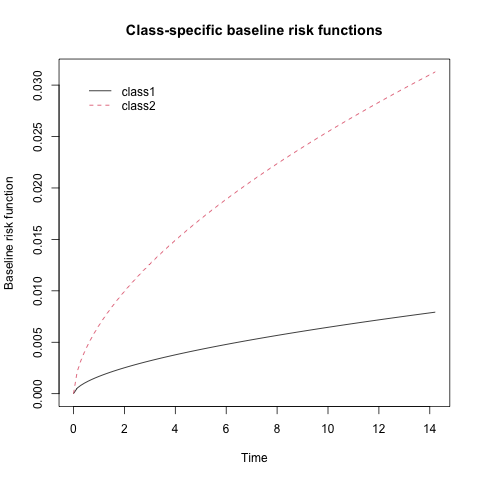

In [24]:
%%R
plot(trained_joint_model, "hazard")

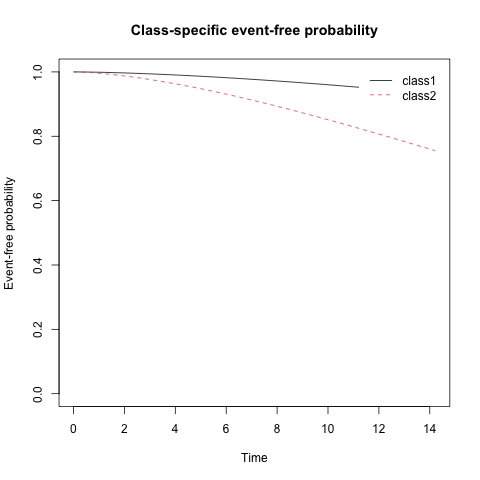

In [25]:
%%R
plot(trained_joint_model, "survival")

4.3 Multivariate shared random effect model
-------------------------------------------

In shared random effect model approach, we considered multivariate joint models for multiple longitudinal outcomes and an event time. Several **R** package exist: *JMbayes*, *rstanarm* and *joineRML* for instance. For reasons of computational cost, flexibility and visibility, we use the *JMbayes* package {2017\_JMbayes}. It allows the estimation of the *lights* model without penalty and assuming that the population is homogeneous (i.e. without assuming latent classes). For a new subject $i$, the predictive marker associated with this model is the dynamic prediction of the conditional survival at time $t+s$ given the suject has survived up to time $t$ and his longitudinal measurements until time $t$. The probability is defined by: 

$$
\Pr\left(T_i^\star>t+s\vert T_i^\star>t,
\mathcal{Y}_{i}(t),\mathcal{D}_n; {\theta}\right)
$$

where 
$\mathcal{Y}_{i}(t)=\{\mathcal{Y}_{i}^1(t),\ldots,\mathcal{Y}_{i}^L(t)\}$ with $\mathcal{Y}_{i}^l(t_{ij}^l)=\{
y_{i}^{l}(t_{ij}^l);0\leq t_{ij}^l\leq t, j=1,\ldots,n_i^l\}$, $\mathcal{D}_n$ is all data from which
the model is estimated, $\theta$ the vector of parameters. The probability is approximated using Monte Carlo technique {2017\_JMbayes}.

In [26]:
%%R
library(JMbayes)
mixed_form <- list()
families <- list()
for(i in 1:length(time_dep_feat)){
    mixed_form[[i]] <- as.formula(paste(time_dep_feat[[i]], " ~ T_long + (T_long | id)"))
    families[[i]] <- gaussian
}

start_time <- Sys.time()
MixedModelFit <- mvglmer(mixed_form, data = data_train, families = families)
surv_form <- as.formula(paste("Surv(T_survival, delta) ~ ", paste(time_indep_feat, collapse = ' + ')))
CoxFit <- coxph(surv_form, data = data_train.id, model = TRUE)

## estimation of Multivariate Joint Model
trained_jmbayes_mv <- mvJointModelBayes(MixedModelFit, CoxFit, timeVar = "T_long")
end_time <- Sys.time()
JMBayes_run_time <- end_time - start_time

data_test$delta[which(data_test$T_survival> t_max)] <- 0
data_test$T_survival[which(data_test$T_survival > t_max)] <- t_max
JMBayes_pred <- survfitJM(object = trained_jmbayes_mv, newdata = data_test, 
                          last.time = data_test$T_survival, survTimes = t_max + 2, 
                          idVar = "id")

R[write to console]: Le chargement a nécessité le package : nlme

R[write to console]: 
Attachement du package : ‘nlme’


R[write to console]: The following objects are masked from ‘package:lcmm’:

    fixef, ranef


R[write to console]: Le chargement a nécessité le package : doParallel

R[write to console]: Le chargement a nécessité le package : foreach

R[write to console]: Le chargement a nécessité le package : iterators

R[write to console]: Le chargement a nécessité le package : rstan

R[write to console]: Le chargement a nécessité le package : StanHeaders

R[write to console]: Le chargement a nécessité le package : ggplot2

R[write to console]: Want to understand how all the pieces fit together? Read R for Data
Science: https://r4ds.had.co.nz/

R[write to console]: rstan (Version 2.21.2, GitRev: 2e1f913d3ca3)

R[write to console]: For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unc

In [27]:
%%R
summary(trained_jmbayes_mv)


Call:
mvJointModelBayes(mvglmerObject = MixedModelFit, survObject = CoxFit, 
    timeVar = "T_long")

Data Descriptives:
Number of Groups: 250		Number of events: 118 (47.2%)
Number of Observations:
  serBilir: 1524
  SGOT: 1524
  albumin: 1524

Random-effects covariance matrix:
      StdDev    Corr                                
(I)1  0.9965  (Int)1  T_lng1  (Int)2  T_lng2  (Int)3
T_l1  0.1850  0.3563                                
(I)2  0.4341  0.6746  0.2915                        
T_l2  0.0666  0.3067  0.8589  0.1876                
(I)3  0.1019 -0.5029 -0.2386 -0.2554 -0.1708        
T_l3  0.0269 -0.5181 -0.7298 -0.3980 -0.6906  0.2488

Survival Outcome:
               PostMean  StDev  StErr    2.5%   97.5%     P
age              0.0426 0.0110 0.0004  0.0215  0.0641 0.000
drugD-penicil   -0.0197 0.2073 0.0060 -0.4003  0.3781 0.932
sexfemale       -0.2697 0.2887 0.0089 -0.8751  0.2879 0.314
serBilir_value   1.3283 0.1851 0.0059  0.9910  1.6990 0.000
SGOT_value      -0.7414 0.4001

5 Evaluation
==========

In [35]:
t = PrettyTable(['Algos', 'C-Index', 'time'])
# Compute C_index
Coxnet_marker = robjects.globalenv["Coxnet_marker"]
Coxnet_c_index = c_index_score(T_test, Coxnet_marker, delta_test)
Coxnet_c_index = max(Coxnet_c_index, 1 - Coxnet_c_index)
Coxnet_exe_time = robjects.globalenv["Coxnet_run_time"][0] * 60
MJLCMM_marker = robjects.globalenv["MJLCMM_marker"]
MJLCMM_c_index = c_index_score(T_test, MJLCMM_marker, delta_test)
MJLCMM_c_index = max(MJLCMM_c_index, 1 - MJLCMM_c_index)
MJLCMM_exe_time = robjects.globalenv["MJLCMM_run_time"][0] * 60
JMBayes_marker = np.array(robjects.globalenv["JMBayes_pred"].rx2('full.results')[0])
JMBayes_c_index = c_index_score(T_test, JMBayes_marker, delta_test)
JMBayes_c_index = max(JMBayes_c_index, 1 - JMBayes_c_index)
JMBayes_exe_time = robjects.globalenv["JMBayes_run_time"][0] * 60
t.add_row(["Cox", "%g" % Coxnet_c_index, "%.3f" % Coxnet_exe_time])
t.add_row(["MJLCMM", "%g" % MJLCMM_c_index, "%.3f" % MJLCMM_exe_time])
t.add_row(["JMBayes", "%g" % JMBayes_c_index, "%.3f" % JMBayes_exe_time])
t.add_row(["lights", "%g" % lights_c_index, "%.3f" % lights_exe_time])
print(t)

+---------+----------+---------+
|  Algos  | C-Index  |   time  |
+---------+----------+---------+
|   Cox   | 0.792994 |  0.102  |
|  MJLCMM | 0.840764 | 536.820 |
| JMBayes | 0.873673 | 320.450 |
|  lights | 0.860403 | 154.512 |
+---------+----------+---------+
